# SET UP

### Import necessary libraries

In [1]:
import json
import csv
import calendar
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from termcolor import colored
from gboml import GbomlGraph
from gboml.compiler.classes import Expression 
import argparse 
from statistics import mean
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib
from IPython.display import display
from builtins import sum as sum
import plotly.graph_objects as go
from collections import defaultdict
import Object as ob
from pandas import DataFrame as df
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(),'..'))
sys.path.append(os.path.join(project_root, 'Modules'))

import GBOML_function as gf
import process_funct as pf
import analyzer_funct as af

from process_funct import merge_dictionaries as merge
from process_funct import convert_mmr_to_dict as convert
from process_funct import transform_dict_into_table_several_column as table
from process_funct import all_cost_prod_dict_per_cluster as node_stat

### Load the model dictionaries for each scenario and the folder path

In [2]:
belgian_data_folder = os.path.join(project_root, 'Data', 'Belgian_model') 
template_folder = os.path.join(project_root, 'Templates')
model_folder = os.path.join(project_root, 'Models GBOML','No efuel')   

### Initialization of the dictionary 

- Where to save plot and results

In [ ]:
scenario_result_folder = os.path.join(project_root, 'Plots' ) 
simulation_folder = os.path.join(project_root, 'Simulations') 

- The dictionnaries:

In [4]:
#################### DME ####################  
model_dme = 'scenario_dme_flex_1years.json'
model_obj_dme = gf.MakeMeReadable(gf.json.load(open(os.path.join(simulation_folder, model_dme))))
file_path = os.path.join(simulation_folder, model_dme)
with open(file_path, 'r') as myfile:
    data = myfile.read()
model_dme_dict = json.loads(data)

#################### DME no economies of scale and no methanol ####################
model_dme_no_scale = 'scenario_dme_no_economies_of_scale_no_methanol_1years.json'
model_obj_dme_no_scale = gf.MakeMeReadable(gf.json.load(open(os.path.join(simulation_folder, model_dme_no_scale))))
file_path = os.path.join(simulation_folder, model_dme_no_scale)
with open(file_path, 'r') as myfile:
    data = myfile.read()
model_dme_no_scale_dict = json.loads(data)

#################### DMEOH ####################
model_dmeoh = 'scenario_dme_no_economies_of_scale_1years.json'
model_obj_dmeoh = gf.MakeMeReadable(gf.json.load(open(os.path.join(simulation_folder, model_dmeoh))))
file_path = os.path.join(simulation_folder, model_dmeoh)
with open(file_path, 'r') as myfile:
    data = myfile.read()
model_dmeoh_dict = json.loads(data)

#################### Ammonia ####################   
model_nh3 = 'scenario_ammonia_1years.json'
# model_nh3 = 'scenario_ammonia_h2_import_cost_135.0_1years.json'
model_obj_nh3 = gf.MakeMeReadable(gf.json.load(open(os.path.join(simulation_folder, model_nh3))))
file_path = os.path.join(simulation_folder, model_nh3)
with open(file_path, 'r') as myfile:
    data = myfile.read()
model_nh3_dict = json.loads(data)

#################### Ammonia flex ####################
model_nh3_flex = 'scenario_ammonia_flex_1years.json'
model_obj_nh3_flex = gf.MakeMeReadable(gf.json.load(open(os.path.join(simulation_folder, model_nh3_flex))))
file_path = os.path.join(simulation_folder, model_nh3_flex)
with open(file_path, 'r') as myfile:
    data = myfile.read()
model_nh3_flex_dict = json.loads(data)

#################### Methanol ####################
model_meoh = 'scenario_methanol_base_case_1years.json'
# model_meoh = 'scenario_methanol_h2_import_cost_135.0_1years.json'  
model_obj_meoh = gf.MakeMeReadable(gf.json.load(open(os.path.join(simulation_folder, model_meoh))))
file_path = os.path.join(simulation_folder, model_meoh)
with open(file_path, 'r') as myfile:
    data = myfile.read()
model_meoh_dict = json.loads(data)

## Class

In [5]:
class Import: # Ancien nom: Object
    def __init__(self, model, solution, name = None):
        
        self.name = name if name is not None else model.get('name', 'No name')
        self.model = model if model is not None else {}
        self.solution = solution if solution is not None else {}
        
        # Parameters (Note: Si l'objet est un fallback, il pourrait ne pas avoir de 'parameters')
        self.parameters = model.get('parameters', {}) 
        # Tente d'initialiser param() uniquement si 'parameters' est présent
        if self.parameters:
            self.param() 
        
        # Variables
        self.variables = solution.get('variables', {})
        # Tente d'initialiser var() uniquement si 'variables' est présent
        if self.variables:
            self.var()
        
        # Objectives
        # Note: L'attribut 'cost' doit être présent même sans objectifs nommés.
        self.objectives = solution.get('objectives', {})
        # Utiliser la valeur 'cost' brute si possible, sinon calculer à partir des objectifs
        self.cost = solution.get('cost', 0.0) 
        
        # Tente de calculer les objectifs si présents
        if self.objectives.get('named'):
            self.objectives_cost()
        
        # Si 'cost' n'a pas été chargé par solution.get('cost', 0.0) ET objectives_cost n'a pas été appelé
        if not hasattr(self, 'cost'):
            setattr(self, 'cost', 0) 
            
    # [Le reste des méthodes attr, get_param, get_var, get_obj, param, var, objectives_cost restent]
    
    def attr(self): 
        for attr, value in vars(self).items():
            print(f"{attr}")
    
    def get_param(self):
        # Utiliser self.parameters sans self.model.get('parameters')
        display(pd.DataFrame(list(self.parameters.keys()), columns=["Parameters"]).style.hide(axis='index'))
        
    def get_var(self):
        # Utiliser self.variables
        display(pd.DataFrame(list(self.variables.keys()), columns=["Variables"]).style.hide(axis='index'))
        
    def get_obj(self):
        display(pd.DataFrame(list(self.objectives.get('named', {}).keys()), columns=["Objectives"]).style.hide(axis="index"))
    
    def param(self):
        for par in self.parameters.keys(): 
            value = self.parameters[par][0] if len(self.parameters[par]) == 1 else self.parameters[par] 
            setattr(self, par, value)
    
    def var(self):
        for var in self.variables.keys(): 
            try: 
                value = self.variables[var]['values'][0] if len(self.variables[var]['values']) == 1 else self.variables[var]['values'] 
            except: 
                value = self.variables[var]
            setattr(self, var, value)

    
    def objectives_cost(self):
        # Cette méthode est appelée SEULEMENT si self.objectives.get('named') est True
        obj = self.objectives.get('named')
        total = 0 
        for o in obj.keys(): 
            value = obj.get(o) 
            setattr(self, o, value) 
            total += value 
        setattr(self, 'cost', total)

class Balance:
    def __init__(self, model, solution, name = None):
        
        self.name = name if name is not None else model.get('name', 'No name')
        self.model = model if model is not None else {}
        self.solution = solution if solution is not None else {}
        self.dual()  # Initialize duals as attributes

    def attr(self): 
        for attr, value in vars(self).items():
            print(f"{attr}")
            
    def dual(self):
        duals = self.solution.get('constraints')
        for d in duals.keys(): 
            value = duals.get(d).get('Pi') 
            setattr(self, d, value)  # Attribut de classe
            
    def node(self):
        display(pd.DataFrame(list(self.model.get('variables_used').keys()), columns=["Nodes"]).style.hide(axis='index'))
        
    def var_used(self):
        display(pd.DataFrame(list(dict.fromkeys(var for vars_list in self.model.get('variables_used', {}).values() for var in vars_list)), columns=["Variables used"]).style.hide(axis='index'))
    
class Node:
    def __init__(self, model, solution, name = None):
        
        self.name = name if name is not None else model.get('name', 'No name')
        self.model = model if model is not None else {}
        self.solution = solution if solution is not None else {}
        
        # Parameters
        self.parameters = model.get('parameters') 
        self.param()  # Initialize parameters as attributes
        
        # Variables
        self.variables = solution.get('variables')
        self.var()  # Initialize variables as attributes
        
        # Objectives
        self.objectives = solution.get('objectives')
        self.objectives_cost()
        
        # Capacity
        self.capacity()
        
    def attr(self): 
        for attr, value in vars(self).items():
            print(f"{attr}")
            
    def info(self):
        print(colored('Node information:', 'blue', attrs=['bold', 'underline']))
        print(f"Name: {self.name}")
        print(f'Number of constraints: {self.model.get("number_constraints")}')
        print(f'Number of variables: {self.model.get("number_variables")}')
        print(f'Number of parameters: {self.model.get("number_parameters")}') 
    
    def get_param(self):
        display(pd.DataFrame(list(self.parameters.keys()), columns=["Parameters"]).style.hide(axis='index'))
        
    def get_var(self):
        display(pd.DataFrame(list(self.variables.keys()), columns=["Variables"]).style.hide(axis='index'))
        
    def get_obj(self):
        display(pd.DataFrame(list(self.objectives.get('named').keys()), columns=["Objectives"]).style.hide(axis="index"))
    
    def param(self):
        for par in self.parameters.keys(): 
            value = self.parameters[par][0] if len(self.parameters[par]) == 1 else self.parameters[par] 
            setattr(self, par, value)  # Attribut de classe
    
    def var(self):
        for var in self.variables.keys(): 
            try: 
                value = self.variables[var]['values'][0] if len(self.variables[var]['values']) == 1 else self.variables[var]['values'] 
            except: 
                value = self.variables[var]
            setattr(self, var, value)  # Attribut de classe
    
    def objectives_cost(self):
        obj = self.solution.get('objectives').get('named')
        total = 0      
        for o in obj.keys(): 
            value = obj.get(o) 
            setattr(self, o, value)  # Attribut de classe
            total += value 
        setattr(self, 'cost', total)  # Attribut de classe
    
    def capacity(self):
        cap = self.pre_installed_capacity + self.new_capacity
        setattr(self, 'capacity', cap)
    
    def cap_table(self, unit = None): 
        df = pd.DataFrame({"Node": [self.name], "Max Capacity": [self.max_capacity], "Pre-installed Capacity": [self.pre_installed_capacity], 
                            "New Capacity": [self.new_capacity], "Installed Capacity": [self.capacity]})
        if unit is not None:
            df.insert(1, "Unit", unit)
        return (df.style.hide(axis="index"))
        
    def stat(self, var, unit = ' ', unit_energy = ' '):
        
        values = getattr(self, var)
        return (pd.DataFrame({"Capacity " + unit: [self.capacity], "Yearly Production " + unit_energy: [sum(values)],
            "Max Production " + unit_energy: [max(values)], "Min Production " + unit_energy: [min(values)], "Average Production " + unit_energy: [mean(values)]}).style.hide(axis="index"))
        
    def summary(self):
        print(colored('Node summary:', 'blue', attrs=['bold', 'underline']))
        print(f"Name: {self.name}")
        print(f"Cost: {round(self.cost,2)} M€")
        print(f"Installed Capacity: {round(self.capacity,2)}")
        for var in self.variables.keys():
            if 'capacity' in var:
                continue
            print(f'{var.replace("_", " ").capitalize()}: {sum(getattr(self, var))}')

class Storage:
    def __init__(self, model, solution, name = None):
        
        self.name = name if name is not None else model.get('name', ' - ')
        self.model = model if model is not None else {}
        self.solution = solution if solution is not None else {}
        
        # Parameters
        self.parameters = model.get('parameters') 
        self.param()  # Initialize parameters as attributes
        
        # Variables
        self.variables = solution.get('variables')
        self.var()  # Initialize variables as attributes
        self.net()
        
        # Objectives
        self.objectives = solution.get('objectives')
        self.objectives_cost()
        
        # Capacity
        self.capacity()
        
        # Net flow rate
        char, disch = [], []

        
    def attr(self): 
        for attr, value in vars(self).items():
            print(f"{attr}")
        
    def info(self):
        print(colored('Node information:', 'blue', attrs=['bold', 'underline']))
        print(f"Name: {self.name}")
        print(f'Number of constraints: {self.model.get("number_constraints")}')
        print(f'Number of variables: {self.model.get("number_variables")}')
        print(f'Number of parameters: {self.model.get("number_parameters")}') 
    
    def get_param(self):
        display(pd.DataFrame(list(self.parameters.keys()), columns=["Parameters"]).style.hide(axis='index'))
        
    def get_var(self):
        display(pd.DataFrame(list(self.variables.keys()), columns=["Variables"]).style.hide(axis='index'))
        
    def get_obj(self):
        display(pd.DataFrame(list(self.objectives.get('named').keys()), columns=["Objectives"]).style.hide(axis="index"))
    
    def param(self):
        for par in self.parameters.keys(): 
            value = self.parameters[par][0] if len(self.parameters[par]) == 1 else self.parameters[par] 
            setattr(self, par, value)  # Attribut de classe
    
    def var(self):
        for var in self.variables.keys(): 
            try: 
                value = self.variables[var]['values'][0] if len(self.variables[var]['values']) == 1 else self.variables[var]['values'] 
            except: 
                value = self.variables[var]
            setattr(self, var, value)  # Attribut de classe
    
    def objectives_cost(self):
        obj = self.solution.get('objectives').get('named')
        total = 0      
        for o in obj.keys(): 
            value = obj.get(o) 
            setattr(self, o, value)  # Attribut de classe
            total += value 
        setattr(self, 'cost', total)  # Attribut de classe
    
    def net(self):
        char = getattr(self, next(key for key in self.variables.keys() if 'charged' in key))
        disch = getattr(self, next(key for key in self.variables.keys() if 'discharged' in key))

        net = [d - c for c, d in zip(char, disch)]
        setattr(self, 'net_flow', net)
        
    
    def capacity(self):
        
        setattr(self, 'max_capacity_energy', self.max_capacity_energy if 'max_capacity_energy' in self.parameters.keys() else self.max_capacity_stock)
        setattr(self, 'max_capacity_power', self.max_capacity_power if 'max_capacity_power' in self.parameters.keys() else self.max_capacity_flow)
        setattr(self, 'pre_installed_capacity_energy', self.pre_installed_capacity_energy if 'pre_installed_capacity_energy' in self.parameters.keys() else self.pre_installed_capacity_stock)
        setattr(self, 'pre_installed_capacity_power', self.pre_installed_capacity_power if 'pre_installed_capacity_power' in self.parameters.keys() else self.pre_installed_capacity_flow)
        setattr(self, 'new_energy_capacity', self.new_energy_capacity if 'new_energy_capacity' in self.variables.keys() else self.capacity_stock)
        setattr(self, 'new_power_capacity', self.new_power_capacity if 'new_power_capacity' in self.variables.keys() else self.capacity_flow)
        
        cap_energy = self.pre_installed_capacity_energy + self.new_energy_capacity
        setattr(self, 'storage_capacity', cap_energy)
        
        cap_power = self.pre_installed_capacity_power + self.new_power_capacity 
        setattr(self, 'discharged_rate', cap_power)
        
        if 'max_charged' in self.parameters.keys():
            setattr(self, 'charged_rate', self.discharged_rate * self.max_charged)
        else:
            setattr(self, 'charged_rate', self.discharged_rate)
            
        
    def cap_table(self, unit = None): 
        
        
            
        df = pd.DataFrame({"Node": [self.name], 
                            "Max Storage capacity": [self.max_capacity_energy], "Pre-installed Storage capacity": [self.pre_installed_capacity_energy], 
                            "New storage capacity": [self.new_energy_capacity], "Installed Capacity": [self.storage_capacity],
                            
                            "Max Flow rate": [self.max_capacity_power], "Max Discharge Flow rate": [self.discharged_rate], "Max Charged Flow rate": [self.charged_rate],})
        if unit is not None:
            df.insert(1, "Unit", unit)
        return (df.style.hide(axis="index"))
        
    def stat(self, unit = ' ', unit_energy = ' '):
        
        
        return (pd.DataFrame({'Name': self.name, "Storage capacity " + unit: [self.storage_capacity], "Net yearly energy stored " + unit_energy: [sum(self.net_flow)],
            "Max charge flow rate " + unit_energy: [self.charged_rate], 
            'Energy charged yearly ' + unit_energy: [sum(getattr(self, next((k for k in self.variables.keys() if 'charged' in k), None)) )],
            "Max discharge flow rate " + unit_energy: [self.discharged_rate], 
            'Energy discharged yearly ' + unit_energy: [sum(getattr(self, next((k for k in self.variables.keys() if 'discharged' in k), None)) )]}).style.hide(axis="index"))
        
        
    def summary(self):
        print(colored('Node summary:', 'blue', attrs=['bold', 'underline']))
        print(f"Name: {self.name}")
        print(f"Cost: {round(self.cost,2)} M€")
        print(f"Storage capacity: {round(self.storage_capacity,2)}")
        print(f"Max charge flow rate: {round(self.charged_rate,2)}")
        print(f"Max discharge flow rate: {round(self.discharged_rate,2)}")

class Cluster: 
    
    def __init__(self, model, solution, name = None):
        
        self.name = name if name is not None else model.get('name', 'No name')
        self.model = model if model is not None else {}
        self.solution = solution if solution is not None else {}
        
        # Parameters
        self.parameters = model.get('parameters') 
        self.param()  # Initialize parameters as attributes
        
        # Variables
        self.variables = solution.get('variables')
        self.var()  # Initialize variables as attributes
        
        # Assets
        try:
            self.asset()
        except:
            pass
        
        # Objectives
        self.objectives = solution.get('objectives')
        self.objectives_cost()
        
        # Constraints
        self.constraints()
        try:
            self.dual()
        except:
            pass
        
    def attr(self): 
        for attr, value in vars(self).items():
            print(f"{attr}")
            
    def get_param(self):
        display(pd.DataFrame(list(self.parameters.keys()), columns=["Parameters"]).style.hide(axis='index'))
        
    def get_var(self):
        display(pd.DataFrame(list(self.variables.keys()), columns=["Variables"]).style.hide(axis='index'))
        
    def get_obj(self):
        return(pd.DataFrame(list(self.objectives.get('named').keys()), columns=["Objectives"]).style.hide(axis="index"))
    
    def param(self):
        for par in self.parameters.keys(): 
            value = self.parameters[par][0] if len(self.parameters[par]) == 1 else self.parameters[par] 
            setattr(self, par, value)  # Attribut de classe
    
    def var(self):
        for var in self.variables.keys(): 
            try: 
                value = self.variables[var]['values'][0] if len(self.variables[var]['values']) == 1 else self.variables[var]['values'] 
            except: 
                value = self.variables[var]
            setattr(self, var, value)  # Attribut de classe
    
    def cost_table(self):
        df = pd.DataFrame([{'Node': n, 'Cost (M€)': round(float(getattr(getattr(self, n, None), 'cost', 0)), 2)} 
                        for n in self.solution.get('sub_elements', {}) 
                        # CORRECTION : La condition 'if ... != 0' est retirée ici.
                        ])
        return (df.style.hide(axis='index'))
        
    def objectives_cost(self):
        obj = self.solution.get('objectives', {}).get('named', {})
        
        # CORRECTION: Suppression de la condition 'if ... != 0' pour inclure tous les nœuds dans le coût total.
        nodes = sum(float(getattr(getattr(self, n, None), 'cost', 0)) for n in self.solution.get('sub_elements', {}))
        setattr(self, 'nodes_cost', nodes)
        
        # Si pas d'objectifs nommés, le coût total est le coût des nœuds.
        if not obj:
            setattr(self, 'cost', nodes)
            return
        
        # Si objectifs nommés existent (ENS, par exemple) :
        cluster = sum(obj.values())
        setattr(self, 'cluster_cost', cluster)
        
        for o, value in obj.items(): 
            setattr(self, o, value)
        
        # Le coût total est la somme des coûts des objectifs (cluster) et des nœuds.
        setattr(self, 'cost', cluster + nodes)

    def constraints(self):
        cons = self.solution.get('constraints', {})  # {} par défaut
        for c in cons.keys(): 
            value = cons.get(c).get('Pi') 
            setattr(self, c, value)
            
    def asset(self): 
        node = self.solution.get('sub_elements') 
        for n in node.keys():
            sub_model = self.model.get('sub_nodes', {}).get(n, {})
            sub_solution = self.solution.get('sub_elements', {}).get(n, {})
            
            # 1. Initialisation : node_obj stockera l'objet créé (Balance, Storage, Node, ou Import)
            node_obj = None
            
            # 2. Test Balance
            if sub_solution.get('constraints'):
                try:
                    # Tente de créer un objet Balance
                    balance = Balance(sub_model, sub_solution, n)
                    # Vérifie la validité du Balance (présence de contraintes)
                    if balance.solution.get('constraints'):
                        node_obj = balance
                except:
                    pass # Si Balance échoue, on continue aux tests suivants
            
            # 3. Test Storage (exécuté SEULEMENT si Balance n'a pas été créé)
            if node_obj is None: 
                storage_vars = sub_solution.get('variables', {})
                has_charge = any('charged' in key for key in storage_vars.keys())
                has_discharge = any('discharged' in key for key in storage_vars.keys())
                
                if has_charge and has_discharge:
                    try:
                        node_obj = Storage(sub_model, sub_solution, n)
                    except:
                        pass # Si Storage échoue, on continue au test par défaut
                
            # 4. Default: standard Node ou Import (exécuté SEULEMENT si aucun type spécifique n'a été créé)
            if node_obj is None: 
                try:
                    node_obj = Node(sub_model, sub_solution, n)
                except:
                    # Dernier recours : Utilisation de la classe de fallback 'Import'
                    # REMPLACÉ: Object(sub_model, sub_solution, n)
                    node_obj = Import(sub_model, sub_solution, n)
                    
            # 5. Attacher l'objet créé à l'instance Cluster
            setattr(self, n, node_obj) 
            
            # 6. Fiabilité du Coût : Assurer que l'attribut 'cost' est présent et correct
            # Cette étape est cruciale si les constructeurs de Balance/Storage/Node ont manqué de le charger.
            if not hasattr(node_obj, 'cost'):
                cost_value = sub_solution.get('cost', 0.0)
                setattr(node_obj, 'cost', cost_value)
                
                
    try:
        def cap_table(self, unit = None): 
            df = pd.DataFrame({"Node": [self.name], "Max Capacity": [self.max_capacity], "Pre-installed Capacity": [self.pre_installed_capacity], 
                                "New Capacity": [self.new_capacity], "Installed Capacity": [self.pre_installed_capacity + self.new_capacity]})
            if unit is not None:
                df.insert(1, "Unit", unit)
            return (df.style.hide(axis="index"))
            
        def stat(self, var, unit = ' ', unit_energy = ' '):
            
            values = getattr(self, var)
            return (pd.DataFrame({"Capacity " + unit: [self.pre_installed_capacity + self.new_capacity], "Yearly Production " + unit_energy: [sum(values)],
                "Max Production " + unit_energy: [max(values)], "Min Production " + unit_energy: [min(values)], "Average Production " + unit_energy: [mean(values)]}).style.hide(axis="index"))   

    except:
        def capacity(self):
            
            setattr(self, 'max_capacity_energy', self.max_capacity_energy if 'max_capacity_energy' in self.parameters.keys() else self.max_capacity_stock)
            setattr(self, 'max_capacity_power', self.max_capacity_power if 'max_capacity_power' in self.parameters.keys() else self.max_capacity_flow)
            setattr(self, 'pre_installed_capacity_energy', self.pre_installed_capacity_energy if 'pre_installed_capacity_energy' in self.parameters.keys() else self.pre_installed_capacity_stock)
            setattr(self, 'pre_installed_capacity_power', self.pre_installed_capacity_power if 'pre_installed_capacity_power' in self.parameters.keys() else self.pre_installed_capacity_flow)
            setattr(self, 'new_energy_capacity', self.new_energy_capacity if 'new_energy_capacity' in self.variables.keys() else self.capacity_stock)
            setattr(self, 'new_power_capacity', self.new_power_capacity if 'new_power_capacity' in self.variables.keys() else self.capacity_flow)
            
            cap_energy = self.pre_installed_capacity_energy + self.new_energy_capacity
            setattr(self, 'storage_capacity', cap_energy)
            
            cap_power = self.pre_installed_capacity_power + self.new_power_capacity 
            setattr(self, 'discharged_rate', cap_power)
            
            if 'max_charged' in self.parameters.keys():
                setattr(self, 'charged_rate', self.discharged_rate * self.max_charged)
            else:
                setattr(self, 'charged_rate', self.discharged_rate)
                
            
        def cap_table(self, unit = None): 
            
            
                
            df = pd.DataFrame({"Node": [self.name], 
                                "Max Storage capacity": [self.max_capacity_energy], "Pre-installed Storage capacity": [self.pre_installed_capacity_energy], 
                                "New storage capacity": [self.new_energy_capacity], "Installed Capacity": [self.storage_capacity],
                                
                                "Max Flow rate": [self.max_capacity_power], "Max Discharge Flow rate": [self.discharged_rate], "Max Charged Flow rate": [self.charged_rate],})
            if unit is not None:
                df.insert(1, "Unit", unit)
            return (df.style.hide(axis="index"))
        
        
        
    def search(self, name):
        result = {}
        sub_elements = self.solution.get('sub_elements', {}) 
        
        for node in sub_elements.keys():
            node_obj = getattr(self, node) 
            if hasattr(node_obj, name):
                result[node] = getattr(node_obj, name)   
        
        return result
    
    def dual(self):
        duals = self.solution.get('constraints')
        for d in duals.keys(): 
            value = duals.get(d).get('Pi') 
            setattr(self, d, value)  # Attribut de classe            

class System:
    def __init__(self, model_dict, name = None):
        self.name = name if name is not None else model_dict.get('model', {}).get('name', 'No name')
        self.clusters = {}
        self.model_dict = model_dict
        self.parameters = model_dict.get('model', {}).get('global_parameters', {})  # ← Ajouter cette ligne
        self.load_all_clusters()
        self.load_all_balances()
        self.global_parameters()
        self.cost = model_dict.get('solution', {}).get('objective', {})  # ← Ajouter cette ligne 
    
        self.list_clusters()

    def attr(self): 
        for attr, value in vars(self).items():
            print(f"{attr}")
            
    def load_all_clusters(self):
        for cluster_name in self.model_dict['model']['nodes'].keys():
            model = self.model_dict['model']['nodes'][cluster_name]
            solution = self.model_dict['solution']['elements'][cluster_name]
            # try: 
            self.clusters[cluster_name] = Cluster(model, solution, cluster_name)
            # except:
            #     self.clusters[cluster_name] = Object(model, solution, cluster_name)
            
    def load_all_balances(self):
        for cluster_name in self.model_dict['model']['hyperedges'].keys(): 
            model = self.model_dict['model']['hyperedges'][cluster_name]
            solution = self.model_dict['solution']['elements'][cluster_name]
            try: 
                self.clusters[cluster_name] = Balance(model, solution, cluster_name)
            except:
                self.clusters[cluster_name] = Object(model, solution, cluster_name) 
            
    def __getattr__(self, name):
        if name in self.clusters:
            return self.clusters[name]
        raise AttributeError(f"Cluster '{name}' not found")
    
    def list_clusters(self):
        setattr(self, 'cluster',list(self.clusters.keys()))
    
    def get_cluster(self, name):
        return self.clusters.get(name)
    
    def global_parameters(self):
        for par in self.parameters.keys(): 
            value = self.parameters[par][0] if len(self.parameters[par]) == 1 else self.parameters[par] 
            setattr(self, par, value)
    
    def get_global_param(self):
        return (pd.DataFrame(list(self.parameters.keys()), columns=["Global Parameters"]).style.hide(axis='index'))
        
    def system_cost(self):
        cost = {}
        for cluster in self.cluster:
            # print(f"{cluster}: {round(getattr(self, cluster).cost, 2)} M€") if hasattr(getattr(self, cluster), 'cost') else f"{cluster}: 0 M€"   
            cost[cluster] = round(getattr(self, cluster).cost, 2) if hasattr(getattr(self, cluster), 'cost') and round(getattr(self, cluster).cost, 2) != 0 else 0
        return (pd.DataFrame(list(cost.items()), columns=["Cluster", "Cost (M€)"]).style.hide(axis='index'))
    
    def search(self, name):
        dict = {}
        
        for cluster in self.clusters.keys():
            cluster_obj = getattr(self, cluster) 
            try:
                dict[cluster] = cluster_obj.search(name)
            except:
                pass

        return dict

# Results

In [6]:
# Class initialization for different models
dme = System(model_dme_dict)
dme_no_scale = System(model_dme_no_scale_dict)
nh3 = System(model_nh3_dict)
nh3_flex = System(model_nh3_flex_dict)
meoh = System(model_meoh_dict)
dmeoh = System(model_dmeoh_dict)
sys = System(model_meoh_dict)

# Lower Heating Values (LHV) in kWh/kg
lhv_h2 = 33.33  # kWh/kg
lhv_nh3 = 6.25 # kWh/kg
lhv_methanol = 5.51 # kWh/kg
lhv_dme = 8.01 # kWh/kg
lhv_kerosene = 12.22 

## Ammonia

- Ammonia supply and storage

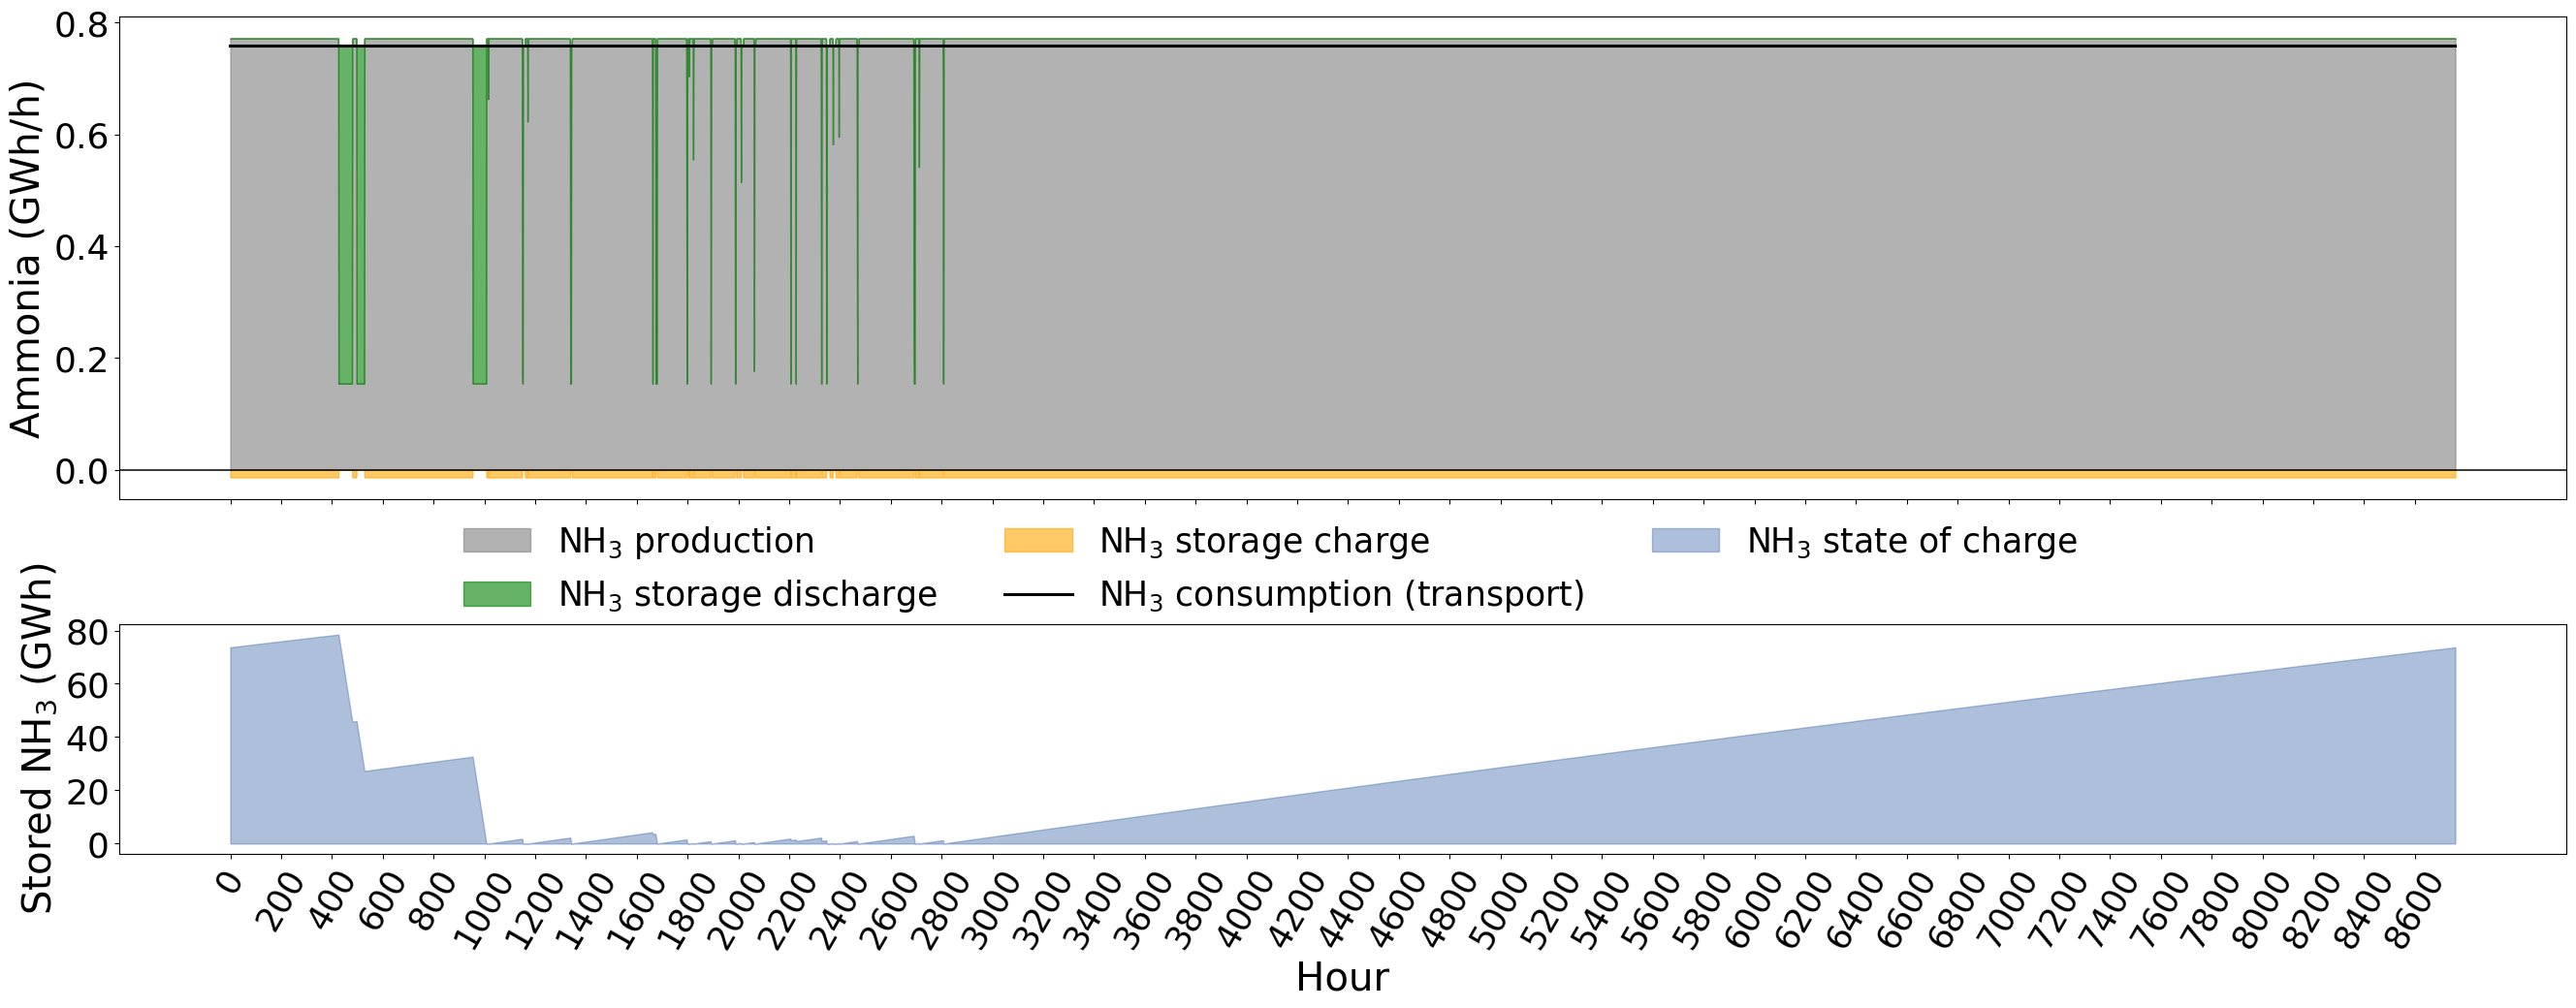

In [7]:
# ================= GLOBAL STYLE =================
plt.rcParams.update({
    "axes.labelsize": 29,
    "xtick.labelsize": 25,
    "ytick.labelsize": 26,
    "legend.fontsize": 25
})

# ================= DATA =================
nh3_prod  = np.array(nh3_flex.INLAND.NH3_PLANTS.nh3_produced)
nh3_char  = np.array(nh3_flex.INLAND.NH3_STORAGE.nh3_charged)
nh3_disch = np.array(nh3_flex.INLAND.NH3_STORAGE.nh3_discharged)
nh3_cons  = np.array([
    t + s for t, s in zip(
        nh3_flex.INLAND.demand_efuel_truck,
        nh3_flex.INLAND.demand_efuel_shipping
    )
])
soc = np.array(nh3_flex.INLAND.NH3_STORAGE.nh3_stored)

# Netflow: + discharge / − charge
nh3_netflow = nh3_disch - nh3_char
hours = np.arange(len(nh3_prod))

# ================= FIGURE =================
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    figsize=(27, 12),
    sharex=True,
    gridspec_kw={"height_ratios": [2.1, 1], "hspace": 0.35}
)

# =================================================
# ============ TOP: PROD / STORAGE / CONS ==========
# =================================================
ax_top.fill_between(
    hours, 0, nh3_prod,
    alpha=0.6, color="gray",
    label="NH$_3$ production"
)

ax_top.fill_between(
    hours,
    nh3_prod,
    nh3_prod + np.clip(nh3_netflow, 0, None),
    alpha=0.6, color="green",
    label="NH$_3$ storage discharge"
)

ax_top.fill_between(
    hours,
    0,
    np.clip(nh3_netflow, None, 0),
    alpha=0.6, color="orange",
    label="NH$_3$ storage charge"
)

ax_top.plot(
    hours,
    nh3_cons,
    color="black",
    linewidth=2.2,
    label="NH$_3$ consumption (transport)"
)

ax_top.axhline(0, color="black", linewidth=1.1)
ax_top.set_ylabel("Ammonia (GWh/h)")
ax_top.grid(False)

# =================================================
# ============== BOTTOM: SOC ======================
# =================================================
ax_bot.fill_between(
    hours, 0, soc,
    alpha=0.45, color="#4C72B0",
    label="NH$_3$ state of charge"
)

ax_bot.set_ylabel("Stored NH$_3$ (GWh)")
ax_bot.set_xlabel("Hour")
ax_bot.grid(False)

# ================= X-TICKS =================
xticks = np.arange(0, len(hours), 200)
ax_bot.set_xticks(xticks)
ax_bot.set_xticklabels(xticks, rotation=60)
ax_bot.set_yticks(np.arange(0, 80+1, 20))

# =================================================
# ================= SINGLE LEGEND =================
# =================================================
h_top, l_top = ax_top.get_legend_handles_labels()
h_bot, l_bot = ax_bot.get_legend_handles_labels()

fig.legend(
    h_top + h_bot,
    l_top + l_bot,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.47),
    ncol=3,
    frameon=False
)

# ================= LAYOUT FIX =================
fig.subplots_adjust(
    left=0.06,
    right=0.995,
    bottom=0.16,
    top=0.88
)

# ================= SAVE =================
plt.savefig(os.path.join(scenario_result_folder,
    "nh3_production_storage_balance.pdf"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()


- Ammonia production cost

In [8]:

# Electricity cost of efuel plants 
e_price = nh3.INLAND_BALANCE.electricity
e_cons = nh3.INLAND.NH3_PLANTS.e_consumed  
e_cost = [p * c for p, c in zip(e_price, e_cons)] # M€ 

# Hydrogen cost of efuel plants
h2_price = nh3.INLAND_BALANCE.hydrogen   
h2_cons = nh3.INLAND.NH3_PLANTS.h2_consumed 
h2_cost = [p * c for p, c in zip(h2_price, h2_cons)] # M€

# Nitrogen cost of efuel plants
n2_e_cons = nh3.INLAND.N2_PLANTS.e_consumed   # Consumption of electricity by N2 plants
n2_e_cost = [p * c for p, c in zip(e_price, n2_e_cons)] # Cost of electricity for N2 production
n2_price = nh3.INLAND.N2_PLANTS.cost + sum(n2_e_cost) # M€  
n2_prod = sum(nh3.INLAND.N2_PLANTS.n2_produced) # kton
n2_mean_cost = n2_price / n2_prod  if n2_prod > 0 else 0 # M€/kton - mean cost of nitrogen production
n2_cons = nh3.INLAND.NH3_PLANTS.n2_consumed
n2_cost = [n2_mean_cost * c / 1 for c in nh3.INLAND.NH3_PLANTS.n2_consumed] # M€   

# Objectives of efuel plants
ammonia_obj = nh3.INLAND.NH3_PLANTS.cost  # M€

print(f'Objective of Ammonia Plants:', round(ammonia_obj, 3), 'M€\n')

print(colored(f'COMMODITIES CONSUMPTION:', 'blue'))
print(f'Hydrogen consumption:', round(sum(h2_cons), 3), 'GWh')
print(f'Nitrogen consumption:', round(sum(n2_cons), 3), 'kton')
print(f'Electricity consumption:', round(sum(e_cons), 3), 'GWh\n')

print(colored(f'COMMODITIES COST:', 'blue'))
print(f'Hydrogen cost:', round(sum(h2_cost), 3), 'M€')
print(f'Nitrogen cost:', round(sum(n2_cost), 3), 'M€')
print(f'Electricity cost:', round(sum(e_cost), 3), 'M€\n')


print(colored(f'Ammonia Plants:', 'blue'))
total_cost = sum(e_cost) + sum(n2_cost) + sum(h2_cost) + ammonia_obj
print(f'Total cost:', round(total_cost, 3), 'M€')

ammonia_prod = nh3.INLAND.NH3_PLANTS.nh3_produced 
print(f'Ammonia production:', round(sum(ammonia_prod), 3), 'GWh')

print(f'Ammonia production cost per MWh:', round(1000*(total_cost) / sum(ammonia_prod), 3), '€/MWh') if sum(ammonia_prod) > 0 else 0   
print(f"Ammonia production cost per kg:", round(lhv_nh3*total_cost / sum(ammonia_prod), 3), '€/kg') if sum(ammonia_prod) > 0 else 0  
print(f"Ammonia production cost per ton:", round(1000*lhv_nh3*total_cost / sum(ammonia_prod), 3), '€/ton') if sum(ammonia_prod) > 0 else 0   

Objective of Ammonia Plants: 65.915 M€

COMMODITIES CONSUMPTION:
Hydrogen consumption: 6301.43 GWh
Nitrogen consumption: 873.293 kton
Electricity consumption: 637.44 GWh

COMMODITIES COST:
Hydrogen cost: 472.607 M€
Nitrogen cost: 23.357 M€
Electricity cost: 77.948 M€

Ammonia Plants:
Total cost: 639.827 M€
Ammonia production: 6640.0 GWh
Ammonia production cost per MWh: 96.36 €/MWh
Ammonia production cost per kg: 0.602 €/kg
Ammonia production cost per ton: 602.247 €/ton


- Ammonia production cost : flex case

In [9]:

# Electricity cost of efuel plants 
e_price = nh3_flex.INLAND_BALANCE.electricity
e_cons = nh3_flex.INLAND.NH3_PLANTS.e_consumed  
e_cost = [p * c for p, c in zip(e_price, e_cons)] # M€ 

# Hydrogen cost of efuel plants
h2_price = nh3_flex.INLAND_BALANCE.hydrogen   
h2_cons = nh3_flex.INLAND.NH3_PLANTS.h2_consumed 
h2_cost = [p * c for p, c in zip(h2_price, h2_cons)] # M€

# Nitrogen cost of efuel plants
n2_e_cons = nh3_flex.INLAND.N2_PLANTS.e_consumed   # Consumption of electricity by N2 plants
n2_e_cost = [p * c for p, c in zip(e_price, n2_e_cons)] # Cost of electricity for N2 production
n2_price = nh3_flex.INLAND.N2_PLANTS.cost + sum(n2_e_cost) # M€  
n2_prod = sum(nh3_flex.INLAND.N2_PLANTS.n2_produced) # kton
n2_mean_cost = n2_price / n2_prod  if n2_prod > 0 else 0 # M€/kton - mean cost of nitrogen production
n2_cons = nh3_flex.INLAND.NH3_PLANTS.n2_consumed
n2_cost = [n2_mean_cost * c / 1 for c in nh3_flex.INLAND.NH3_PLANTS.n2_consumed] # M€   

# Objectives of efuel plants
ammonia_obj = nh3_flex.INLAND.NH3_PLANTS.cost  # M€

print(f'Objective of Ammonia Plants:', round(ammonia_obj, 3), 'M€\n')

print(colored(f'COMMODITIES CONSUMPTION:', 'blue'))
print(f'Hydrogen consumption:', round(sum(h2_cons), 3), 'GWh')
print(f'Nitrogen consumption:', round(sum(n2_cons), 3), 'kton')
print(f'Electricity consumption:', round(sum(e_cons), 3), 'GWh\n')

print(colored(f'COMMODITIES COST:', 'blue'))
print(f'Hydrogen cost:', round(sum(h2_cost), 3), 'M€')
print(f'Nitrogen cost:', round(sum(n2_cost), 3), 'M€')
print(f'Electricity cost:', round(sum(e_cost), 3), 'M€\n')


print(colored(f'Ammonia Plants:', 'blue'))
total_cost = sum(e_cost) + sum(n2_cost) + sum(h2_cost) + ammonia_obj
print(f'Total cost:', round(total_cost, 3), 'M€')

ammonia_prod = nh3_flex.INLAND.NH3_PLANTS.nh3_produced 
print(f'Ammonia production:', round(sum(ammonia_prod), 3), 'GWh')

print(f'Ammonia production cost per MWh:', round(1000*(total_cost) / sum(ammonia_prod), 3), '€/MWh') if sum(ammonia_prod) > 0 else 0   
print(f"Ammonia production cost per kg:", round(lhv_nh3*total_cost / sum(ammonia_prod), 3), '€/kg') if sum(ammonia_prod) > 0 else 0  
print(f"Ammonia production cost per ton:", round(1000*lhv_nh3*total_cost / sum(ammonia_prod), 3), '€/ton') if sum(ammonia_prod) > 0 else 0   

Objective of Ammonia Plants: 67.089 M€

COMMODITIES CONSUMPTION:
Hydrogen consumption: 6309.379 GWh
Nitrogen consumption: 874.394 kton
Electricity consumption: 638.244 GWh

COMMODITIES COST:
Hydrogen cost: 473.203 M€
Nitrogen cost: 22.384 M€
Electricity cost: 69.946 M€

Ammonia Plants:
Total cost: 632.622 M€
Ammonia production: 6648.376 GWh
Ammonia production cost per MWh: 95.154 €/MWh
Ammonia production cost per kg: 0.595 €/kg
Ammonia production cost per ton: 594.715 €/ton


- Ammonia storage for flex case

In [10]:
nh3_flex.INLAND.NH3_STORAGE.cap_table()

Node,Max Storage capacity,Pre-installed Storage capacity,New storage capacity,Installed Capacity,Max Flow rate,Max Discharge Flow rate,Max Charged Flow rate
NH3_STORAGE,100,0,78.491172,78.491172,100,0.603688,0.603688


- Cost breakdown 

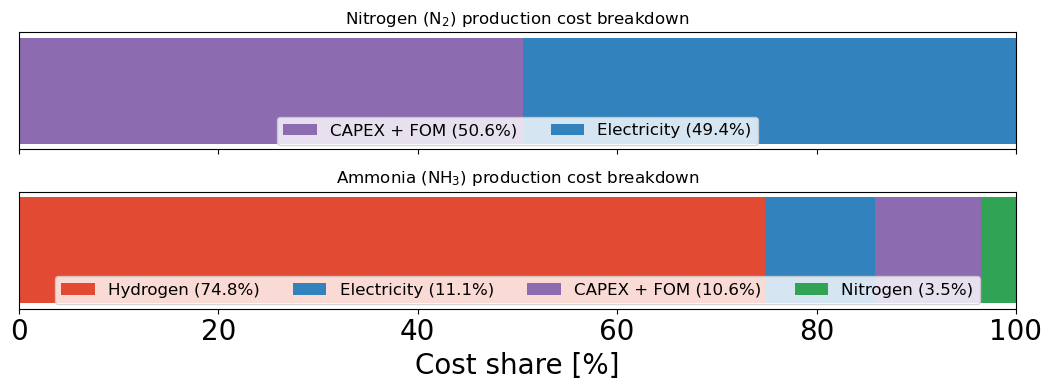

In [11]:
plt.rcParams.update({
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 12
})


# =========================================================
# ===================== N2 COST SHARES ====================
# =========================================================

n2_capex_fom = nh3.INLAND.N2_PLANTS.cost  # M€

n2_e_cons = nh3.INLAND.N2_PLANTS.e_consumed
e_price   = nh3.INLAND_BALANCE.electricity
n2_e_cost = [p * c for p, c in zip(e_price, n2_e_cons)]

n2_elec_cost = sum(n2_e_cost)
n2_total_cost = n2_capex_fom + n2_elec_cost

n2_cost_breakdown = {
    "CAPEX + FOM": n2_capex_fom / n2_total_cost * 100,
    "Electricity": n2_elec_cost / n2_total_cost * 100,
}

n2_cost_breakdown = {
    k: v for k, v in n2_cost_breakdown.items() if v > 0.1
}
n2_cost_breakdown = dict(
    sorted(n2_cost_breakdown.items(), key=lambda x: x[1], reverse=True)
)

# =========================================================
# ===================== NH3 COST SHARES ===================
# =========================================================

capex_fom     = ammonia_obj
h2_cost_tot   = sum(h2_cost)
n2_cost_tot   = sum(n2_cost)
elec_cost_tot = sum(e_cost)

total_cost = capex_fom + h2_cost_tot + n2_cost_tot + elec_cost_tot

nh3_cost_breakdown = {
    "CAPEX + FOM": capex_fom / total_cost * 100,
    "Hydrogen": h2_cost_tot / total_cost * 100,
    "Nitrogen": n2_cost_tot / total_cost * 100,
    "Electricity": elec_cost_tot / total_cost * 100,
}

nh3_cost_breakdown = {
    k: v for k, v in nh3_cost_breakdown.items() if v > 0.1
}
nh3_cost_breakdown = dict(
    sorted(nh3_cost_breakdown.items(), key=lambda x: x[1], reverse=True)
)

# =========================================================
# ===================== PLOT ==============================
# =========================================================

fig, (ax_n2, ax_nh3) = plt.subplots(
    2, 1,
    figsize=(11, 4),
    sharex=True
)

colors = {
    "CAPEX + FOM": "#8c6bb1",
    "Hydrogen": "#e34a33",
    "Nitrogen": "#31a354",
    "Electricity": "#3182bd",
}

# ----------------- N2 (TOP) -----------------
left = 0
for label, value in n2_cost_breakdown.items():
    ax_n2.barh(
        y=0,
        width=value,
        left=left,
        color=colors[label],
        label=f"{label} ({value:.1f}%)"
    )
    left += value

ax_n2.set_xlim(0, 100)
ax_n2.set_yticks([])
ax_n2.set_title("Nitrogen (N$_2$) production cost breakdown")
ax_n2.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.35),
    ncol=len(n2_cost_breakdown)
)

# ----------------- NH3 (BOTTOM) -----------------
left = 0
for label, value in nh3_cost_breakdown.items():
    ax_nh3.barh(
        y=0,
        width=value,
        left=left,
        color=colors[label],
        label=f"{label} ({value:.1f}%)"
    )
    left += value

ax_nh3.set_xlim(0, 100)
ax_nh3.set_yticks([])
ax_nh3.set_title("Ammonia (NH$_3$) production cost breakdown")
ax_nh3.set_xlabel("Cost share [%]")

ax_nh3.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.35),
    ncol=len(nh3_cost_breakdown)
)

plt.tight_layout()
plt.savefig(os.path.join(scenario_result_folder,"n2_nh3_cost_breakdown.pdf"), dpi=300)
plt.show()



## Methanol

- Production

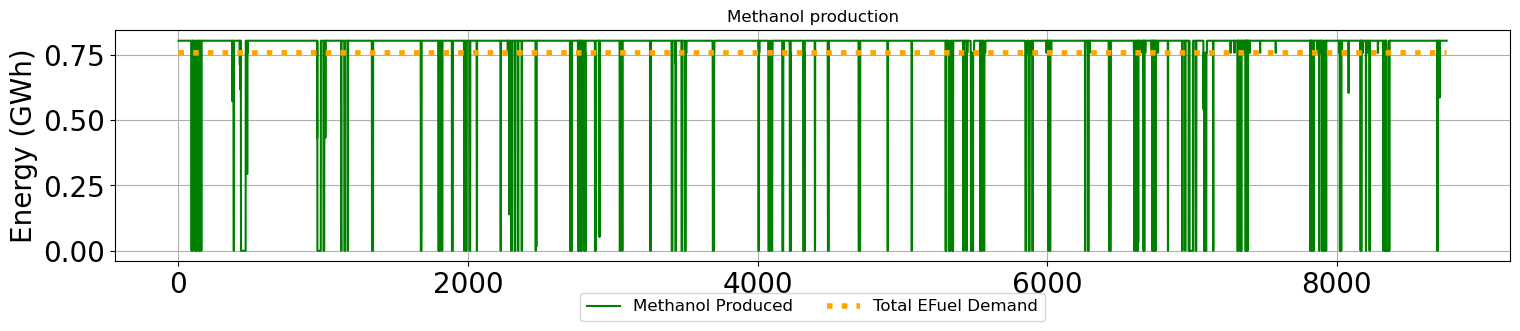

Methanol Plant Summary:
Capacity (GW): 0.804
Total production (GWh): 6640.0
Total production (kton): 1205.082


Capacity GWh,Yearly Production GWh,Max Production GWh,Min Production GWh,Average Production GWh
0.804398,6640.000000,0.804398,0.000000,0.757991


Node,Max Capacity,Pre-installed Capacity,New Capacity,Installed Capacity
METHANOL_PLANTS,100,0.000000,0.804398,0.804398


Total electricity consumption (GWh): 357.909
Hydrogen consumption (GWh): 8392.548
Hydrogen consumption (kton): 251.802
Carbon dioxide consumed (kton): 1650.962


In [12]:

# Production
plt.figure(figsize=(18, 3))  
plt.plot(meoh.INLAND.METHANOL_PLANTS.methanol_produced, label='Methanol Produced', color='green') 
plt.plot([i + j for i, j in zip(meoh.INLAND.demand_efuel_truck, meoh.INLAND.demand_efuel_shipping)], label='Total EFuel Demand', linestyle=':', linewidth=4, color='orange')
plt.ylabel('Energy (GWh)') 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.title('Methanol production'); plt.grid(); plt.show()


print(colored('Methanol Plant Summary:', 'blue', attrs=['bold', 'underline']))

print('Capacity (GW):', round(meoh.INLAND.METHANOL_PLANTS.capacity,3))
print('Total production (GWh):', round(sum(meoh.INLAND.METHANOL_PLANTS.methanol_produced),3))
print('Total production (kton):', round(sum(meoh.INLAND.METHANOL_PLANTS.methanol_produced)/lhv_methanol,3))

display(meoh.INLAND.METHANOL_PLANTS.stat('methanol_produced', unit='GWh', unit_energy='GWh'))
display(meoh.INLAND.METHANOL_PLANTS.cap_table())

print('Total electricity consumption (GWh):', round(sum(meoh.INLAND.METHANOL_PLANTS.e_consumed),3))
print('Hydrogen consumption (GWh):', round(sum(meoh.INLAND.METHANOL_PLANTS.h2_consumed),3))
print('Hydrogen consumption (kton):', round(sum(meoh.INLAND.METHANOL_PLANTS.h2_consumed)/lhv_h2,3))
print('Carbon dioxide consumed (kton):', round(sum(meoh.INLAND.METHANOL_PLANTS.co2_consumed),3))

- Storage

Node,Max Storage capacity,Pre-installed Storage capacity,New storage capacity,Installed Capacity,Max Flow rate,Max Discharge Flow rate,Max Charged Flow rate
METHANOL_STORAGE,100,0,25.013699,25.013699,20.000000,0.757991,0.757991


Name,Storage capacity GWh,Net yearly energy stored GWh,Max charge flow rate GWh,Energy charged yearly GWh,Max discharge flow rate GWh,Energy discharged yearly GWh
METHANOL_STORAGE,25.013699,0.000000,0.757991,378.686050,0.757991,378.686050


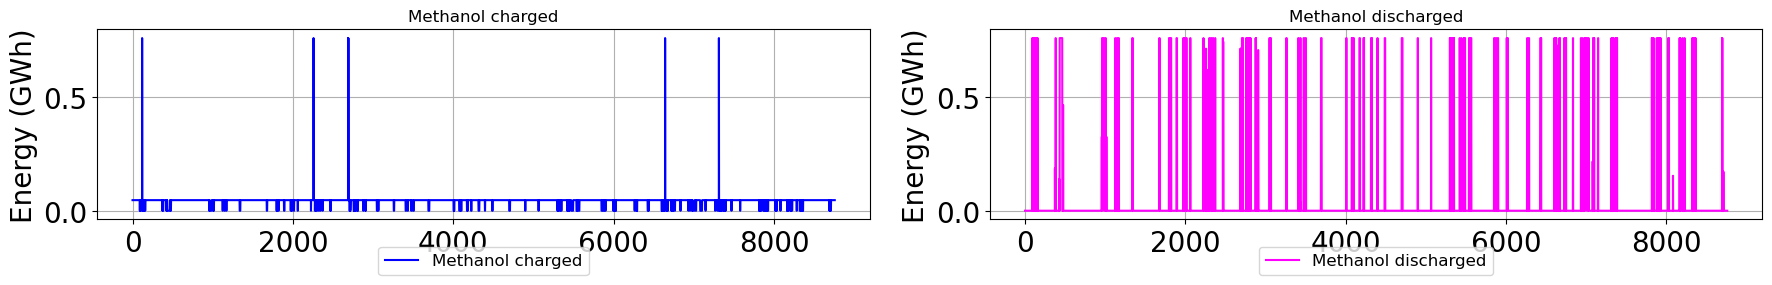

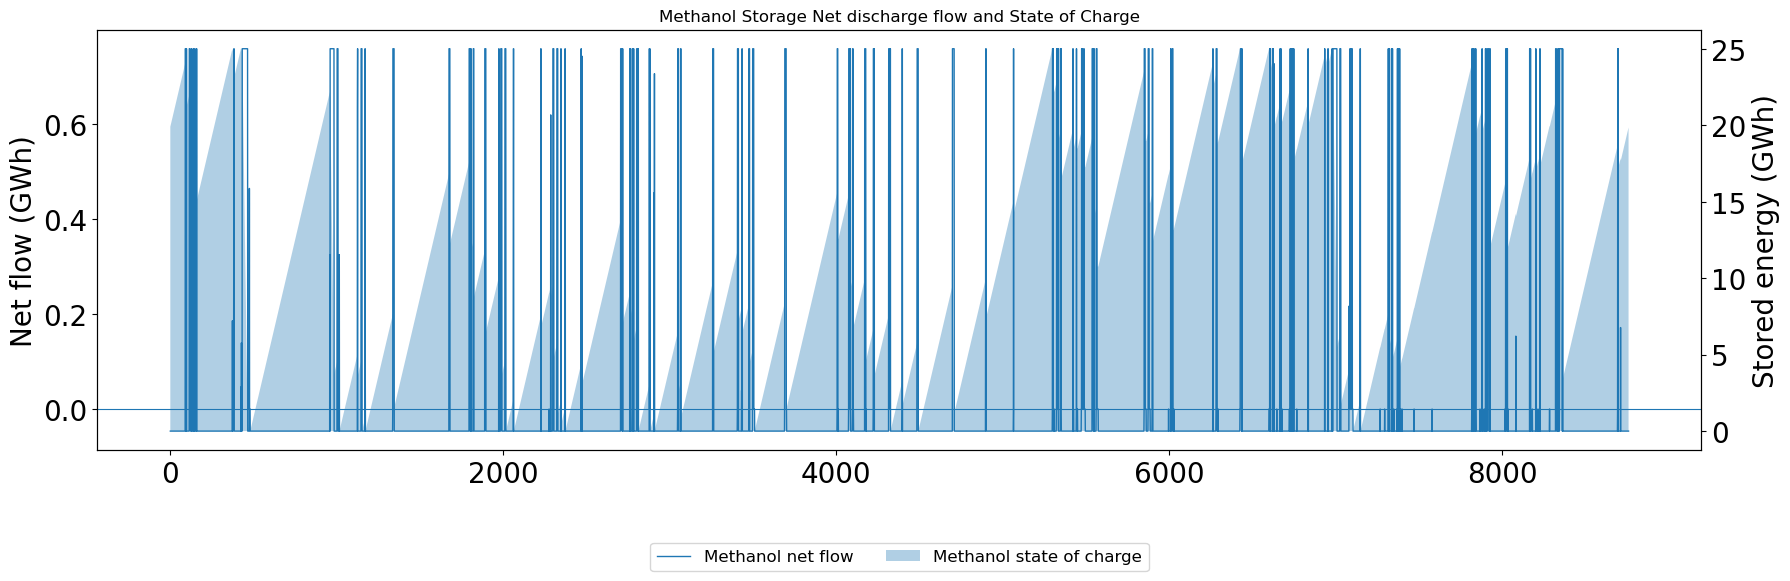

In [13]:
# if methanol == True:
# Storage
display(meoh.INLAND.METHANOL_STORAGE.cap_table())
display(meoh.INLAND.METHANOL_STORAGE.stat(unit='GWh', unit_energy='GWh') ) 

fig, axs = plt.subplots(1, 2, figsize=(18, 3))
axs[0].plot(meoh.INLAND.METHANOL_STORAGE.methanol_charged, label='Methanol charged', color='blue') 
axs[0].set_ylabel('Energy (GWh)')
axs[0].set_title('Methanol charged')
axs[0].grid()  
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
axs[1].plot(meoh.INLAND.METHANOL_STORAGE.methanol_discharged, label='Methanol discharged', color='magenta')   
axs[1].set_ylabel('Energy (GWh)')
axs[1].set_title('Methanol discharged')
axs[1].grid() 
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.tight_layout()

plt.show() 


import matplotlib.pyplot as plt
import numpy as np

# ================= DATA =================
net_flow = np.array(meoh.INLAND.METHANOL_STORAGE.net_flow)
soc = np.array(meoh.INLAND.METHANOL_STORAGE.methanol_stored)
hours = np.arange(len(net_flow))

# ================= PLOT =================
fig, ax1 = plt.subplots(figsize=(18, 6))

# --- Net flow (left axis) ---
ax1.plot(
    hours,
    net_flow,
    label='Methanol net flow',
    linewidth=1
)
ax1.axhline(0, linewidth=0.8)
ax1.set_ylabel('Net flow (GWh)')
ax1.grid(False)

# --- State of charge (right axis, fillbetween) ---
ax2 = ax1.twinx()
ax2.fill_between(
    hours,
    0,
    soc,
    alpha=0.35,
    label='Methanol state of charge'
)
ax2.set_ylabel('Stored energy (GWh)')
ax2.grid(False)

# ================= LEGEND =================
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=2
)

# ================= TITLE =================
plt.title('Methanol Storage Net discharge flow and State of Charge')
plt.tight_layout()
plt.show()


- Methanol supply and storage

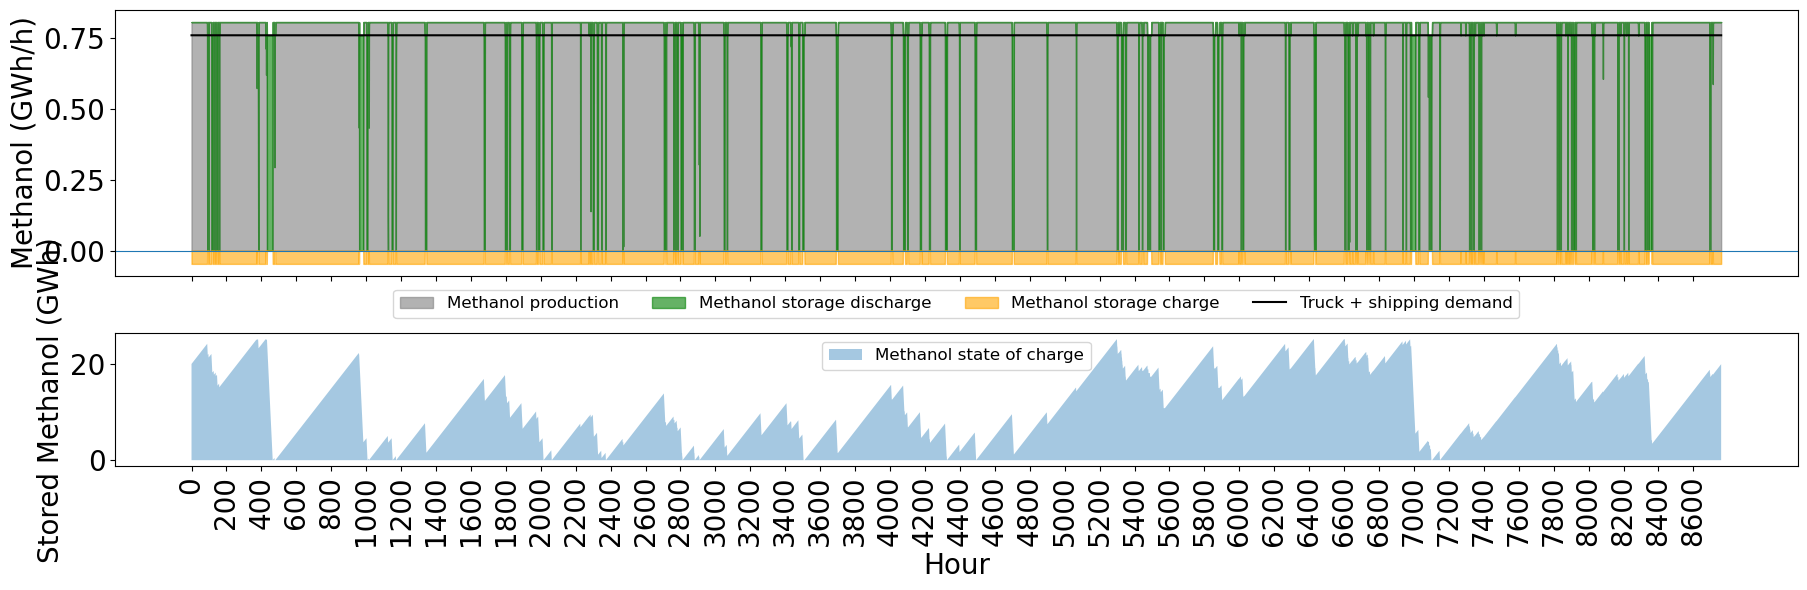

In [14]:
# ================= DATA =================
meoh_prod  = np.array(meoh.INLAND.METHANOL_PLANTS.methanol_produced)
meoh_disch = np.array(meoh.INLAND.METHANOL_STORAGE.methanol_discharged)
meoh_char  = np.array(meoh.INLAND.METHANOL_STORAGE.methanol_charged)
soc        = np.array(meoh.INLAND.METHANOL_STORAGE.methanol_stored)


# DME final consumption (truck + shipping)
dme_cons = np.array(
    [
        t + s
        for t, s in zip(
            meoh.INLAND.demand_efuel_truck,
            meoh.INLAND.demand_efuel_shipping
        )
    ]
)

# Netflow: + discharge / - charge
meoh_netflow = meoh_disch - meoh_char

hours = np.arange(len(meoh_prod))

# ================= PLOT =================
fig, (ax_top, ax_bot) = plt.subplots(
    2,
    1,
    figsize=(18, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1]}
)

# =================================================
# ============ TOP: PROD / STORAGE / CONS ==========
# =================================================

# --- Methanol production ---
ax_top.fill_between(
    hours,
    0,
    meoh_prod,
    alpha=0.6,
    label='Methanol production',
    color='gray'
)

# --- Storage discharge (stacked above production) ---
ax_top.fill_between(
    hours,
    meoh_prod,
    meoh_prod + np.clip(meoh_netflow, 0, None),
    alpha=0.6,
    label='Methanol storage discharge',
    color='green'
)

# --- Storage charge (below zero) ---
ax_top.fill_between(
    hours,
    0,
    np.clip(meoh_netflow, None, 0),
    alpha=0.6,
    label='Methanol storage charge',
    color='orange'
)

# --- DME final demand ---
ax_top.plot(
    hours,
    dme_cons,
    color='black',
    linewidth=1.5,
    label='Truck + shipping demand'
)

ax_top.axhline(0, linewidth=0.8)
ax_top.set_ylabel('Methanol (GWh/h)')
ax_top.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=4
)
ax_top.grid(False)

# =================================================
# ============== BOTTOM: SOC ======================
# =================================================
ax_bot.fill_between(
    hours,
    0,
    soc,
    alpha=0.4,
    label='Methanol state of charge'
)

ax_bot.set_ylabel('Stored Methanol (GWh)')
ax_bot.set_xlabel('Hour')
ax_bot.legend()
ax_bot.grid(False)

# ================= X-TICKS =================
xticks = np.arange(0, len(hours), 200)
ax_bot.set_xticks(xticks)
ax_bot.set_xticklabels(xticks, rotation=90)

plt.tight_layout()
plt.savefig(os.path.join(scenario_result_folder,"methanol_production_storage_dme_netflow.pdf"), dpi=300)
plt.show()


- Production cost

In [15]:

# Electricity cost of efuel plants 
e_price = meoh.INLAND_BALANCE.electricity
e_cons = meoh.INLAND.METHANOL_PLANTS.e_consumed 
e_cost = [p * c for p, c in zip(e_price, e_cons)] # M€

# Hydrogen cost of efuel plants
h2_price = meoh.INLAND_BALANCE.hydrogen 
h2_cons = meoh.INLAND.METHANOL_PLANTS.h2_consumed 
h2_cost = [p * c for p, c in zip(h2_price, h2_cons)] # M€ 

# Carbon dioxide cost
co2_price = meoh.CO2_QUOTA.co2_neutral 
co2_price = -co2_price[0] 
co2_cons = meoh.INLAND.METHANOL_PLANTS.co2_consumed 
co2_cost = [co2_price * c for c in co2_cons] # M€


# Objectives of efuel plants
methanol_obj = meoh.INLAND.METHANOL_PLANTS.cost  # M€

print(f'Objective of Methanol Plants:', round(methanol_obj, 3), 'M€\n')

print(colored(f'COMMODITIES CONSUMPTION:', 'blue'))
print(f'Hydrogen consumption:', round(sum(h2_cons), 3), 'GWh')
print(f'Carbon dioxide consumption:', round(sum(co2_cons), 3), 'kton')
print(f'Electricity consumption:', round(sum(e_cons), 3), 'GWh\n')

print(colored(f'COMMODITIES COST:', 'blue'))
print(f'Hydrogen cost:', round(sum(h2_cost), 3), 'M€') 
print(f'Electricity cost:', round(sum(e_cost), 3), 'M€\n')


print(colored(f'Methanol Plants:', 'blue'))

methanol_prod = meoh.INLAND.METHANOL_PLANTS.methanol_produced 
print(f'Methanol production:', round(sum(methanol_prod), 3), 'GWh\n')

total_cost = sum(e_cost) + sum(h2_cost) + methanol_obj
print(f'Total cost:', round(total_cost, 3), 'M€')
print(f'Methanol production cost per MWh:', round(1000*total_cost / sum(methanol_prod), 3), '€/MWh') if sum(methanol_prod) > 0 else 0 
print(f"Methanol production cost per kg:", round(lhv_methanol*total_cost / sum(methanol_prod), 3), '€/kg') if sum(methanol_prod) > 0 else 0 
print(f"Methanol production cost per ton:", round(1000*lhv_methanol*total_cost / sum(methanol_prod), 3), '€/ton') if sum(methanol_prod) > 0 else 0

Objective of Methanol Plants: 77.437 M€

COMMODITIES CONSUMPTION:
Hydrogen consumption: 8392.548 GWh
Carbon dioxide consumption: 1650.962 kton
Electricity consumption: 357.909 GWh

COMMODITIES COST:
Hydrogen cost: 629.441 M€
Electricity cost: 38.9 M€

Methanol Plants:
Methanol production: 6640.0 GWh

Total cost: 745.778 M€
Methanol production cost per MWh: 112.316 €/MWh
Methanol production cost per kg: 0.619 €/kg
Methanol production cost per ton: 618.861 €/ton


- Cost breakdown

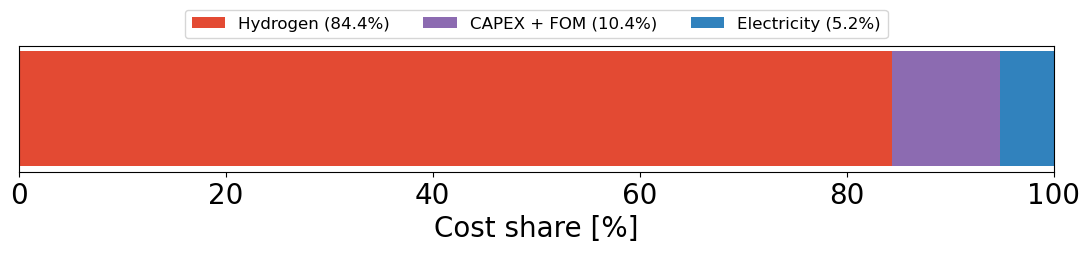

In [16]:

# =========================================================
# ===================== COST COMPONENTS ===================
# =========================================================

capex_fom     = methanol_obj        # M€
h2_cost_tot   = sum(h2_cost)         # M€
elec_cost_tot = sum(e_cost)          # M€

total_cost = capex_fom + h2_cost_tot + elec_cost_tot

if total_cost == 0:
    raise ValueError("Total cost is zero, cannot compute breakdown")

# =========================================================
# ===================== COST SHARES (%) ===================
# =========================================================

cost_breakdown = {
    "CAPEX + FOM": capex_fom / total_cost * 100,
    "Hydrogen": h2_cost_tot / total_cost * 100,
    "Electricity": elec_cost_tot / total_cost * 100,
}

# Remove negligible components
cost_breakdown = {
    k: v for k, v in cost_breakdown.items() if v > 0.1
}

# Sort by decreasing contribution
cost_breakdown = dict(
    sorted(cost_breakdown.items(), key=lambda x: x[1], reverse=True)
)

# =========================================================
# ===================== PLOT ==============================
# =========================================================

fig, ax = plt.subplots(figsize=(11, 3))

left = 0
colors = {
    "CAPEX + FOM": "#8c6bb1",
    "Hydrogen": "#e34a33",
    "Electricity": "#3182bd",
}

for label, value in cost_breakdown.items():
    ax.barh(
        y=0,
        width=value,
        left=left,
        color=colors[label],
        label=f"{label} ({value:.1f}%)"
    )
    left += value

ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_xlabel("Cost share [%]")

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.35),
    ncol=len(cost_breakdown)
)

plt.tight_layout()
plt.savefig(os.path.join(scenario_result_folder,"methanol_cost_breakdown.pdf"), dpi=300)
plt.show()



## DME

- Production cost direct dme 

In [17]:

print(colored('DME Plants Summary:', 'blue', attrs=['bold', 'underline']))
print('DME Plant Capacity (GW):', round(dme.INLAND.DME_PLANTS.capacity,3))
# Electricity cost of efuel plants 
e_price = dme.INLAND_BALANCE.electricity
e_cons = dme.INLAND.DME_PLANTS.e_consumed 
e_cost = [p * c for p, c in zip(e_price, e_cons)] # M€

# Hydrogen cost of efuel plants
h2_price = dme.INLAND_BALANCE.hydrogen 
h2_cons = dme.INLAND.DME_PLANTS.h2_consumed 
h2_cost = [p * c for p, c in zip(h2_price, h2_cons)] # M€ 

# Carbon dioxide cost
co2_price = dme.CO2_QUOTA.co2_neutral 
co2_price = -co2_price[0] 
co2_cons = dme.INLAND.DME_PLANTS.co2_consumed 
co2_cost = [co2_price * c for c in co2_cons] # M€


# Objectives of efuel plants
dme_obj = dme.INLAND.DME_PLANTS.cost  # M€

print('')
print(f'Objective of DME Plants:', round(dme_obj, 3), 'M€\n')

print(colored(f'COMMODITIES CONSUMPTION:', 'blue'))
print(f'Hydrogen consumption:', round(sum(h2_cons), 3), 'GWh')
print(f'Carbon dioxide consumption:', round(sum(co2_cons), 3), 'kton')
print(f'Electricity consumption:', round(sum(e_cons), 3), 'GWh\n')

print(colored(f'COMMODITIES COST:', 'blue'))
print(f'Hydrogen cost:', round(sum(h2_cost), 3), 'M€') 
print(f'Electricity cost:', round(sum(e_cost), 3), 'M€\n')


print(colored(f'DME Plants:', 'blue'))

dme_prod = dme.INLAND.DME_PLANTS.dme_produced 
print(f'DME production:', round(sum(dme_prod), 3), 'GWh\n') 

total_cost = sum(e_cost) + sum(h2_cost) + dme_obj
print(f'Total cost:', round(total_cost, 3), 'M€')
print(f'DME production cost per MWh:', round(1000*total_cost / sum(dme_prod), 3), '€/MWh') if sum(dme_prod) > 0 else 0 
print(f"DME production cost per kg:", round(lhv_dme*total_cost / sum(dme_prod), 3), '€/kg') if sum(dme_prod) > 0 else 0 
print(f"DME production cost per ton:", round(1000*lhv_dme*total_cost / sum(dme_prod), 3), '€/ton') if sum(dme_prod) > 0 else 0

DME Plants Summary:
DME Plant Capacity (GW): 0.761

Objective of DME Plants: 113.237 M€

COMMODITIES CONSUMPTION:
Hydrogen consumption: 8152.262 GWh
Carbon dioxide consumption: 1827.004 kton
Electricity consumption: 248.798 GWh

COMMODITIES COST:
Hydrogen cost: 611.42 M€
Electricity cost: 28.085 M€

DME Plants:
DME production: 6642.897 GWh

Total cost: 752.742 M€
DME production cost per MWh: 113.315 €/MWh
DME production cost per kg: 0.908 €/kg
DME production cost per ton: 907.656 €/ton


- Production cost direct dme no economies of scale

In [18]:

print(colored('DME Plants Summary:', 'blue', attrs=['bold', 'underline']))
print('DME Plant Capacity (GW):', round(dme_no_scale.INLAND.DME_PLANTS.capacity,3))
# Electricity cost of efuel plants 
e_price = dme_no_scale.INLAND_BALANCE.electricity
e_cons = dme_no_scale.INLAND.DME_PLANTS.e_consumed 
e_cost = [p * c for p, c in zip(e_price, e_cons)] # M€

# Hydrogen cost of efuel plants
h2_price = dme_no_scale.INLAND_BALANCE.hydrogen 
h2_cons = dme_no_scale.INLAND.DME_PLANTS.h2_consumed 
h2_cost = [p * c for p, c in zip(h2_price, h2_cons)] # M€ 

# Carbon dioxide cost
co2_price = dme_no_scale.CO2_QUOTA.co2_neutral 
co2_price = -co2_price[0] 
co2_cons = dme_no_scale.INLAND.DME_PLANTS.co2_consumed 
co2_cost = [co2_price * c for c in co2_cons] # M€


# Objectives of efuel plants
dme_obj = dme_no_scale.INLAND.DME_PLANTS.cost  # M€

print('')
print(f'Objective of DME Plants:', round(dme_obj, 3), 'M€\n')

print(colored(f'COMMODITIES CONSUMPTION:', 'blue'))
print(f'Hydrogen consumption:', round(sum(h2_cons), 3), 'GWh')
print(f'Carbon dioxide consumption:', round(sum(co2_cons), 3), 'kton')
print(f'Electricity consumption:', round(sum(e_cons), 3), 'GWh\n')

print(colored(f'COMMODITIES COST:', 'blue'))
print(f'Hydrogen cost:', round(sum(h2_cost), 3), 'M€') 
print(f'Electricity cost:', round(sum(e_cost), 3), 'M€\n')


print(colored(f'DME Plants:', 'blue'))

dme_prod = dme_no_scale.INLAND.DME_PLANTS.dme_produced 
print(f'DME production:', round(sum(dme_prod), 3), 'GWh\n') 

total_cost = sum(e_cost) + sum(h2_cost) + dme_obj
print(f'Total cost:', round(total_cost, 3), 'M€')
print(f'DME production cost per MWh:', round(1000*total_cost / sum(dme_prod), 3), '€/MWh') if sum(dme_prod) > 0 else 0 
print(f"DME production cost per kg:", round(lhv_dme*total_cost / sum(dme_prod), 3), '€/kg') if sum(dme_prod) > 0 else 0 
print(f"DME production cost per ton:", round(1000*lhv_dme*total_cost / sum(dme_prod), 3), '€/ton') if sum(dme_prod) > 0 else 0

DME Plants Summary:
DME Plant Capacity (GW): 0.758

Objective of DME Plants: 559.009 M€

COMMODITIES CONSUMPTION:
Hydrogen consumption: 8148.706 GWh
Carbon dioxide consumption: 1826.207 kton
Electricity consumption: 248.689 GWh

COMMODITIES COST:
Hydrogen cost: 611.153 M€
Electricity cost: 30.479 M€

DME Plants:
DME production: 6640.0 GWh

Total cost: 1200.641 M€
DME production cost per MWh: 180.819 €/MWh
DME production cost per kg: 1.448 €/kg
DME production cost per ton: 1448.364 €/ton


- Cost breakdown for direct dme no economies of scale

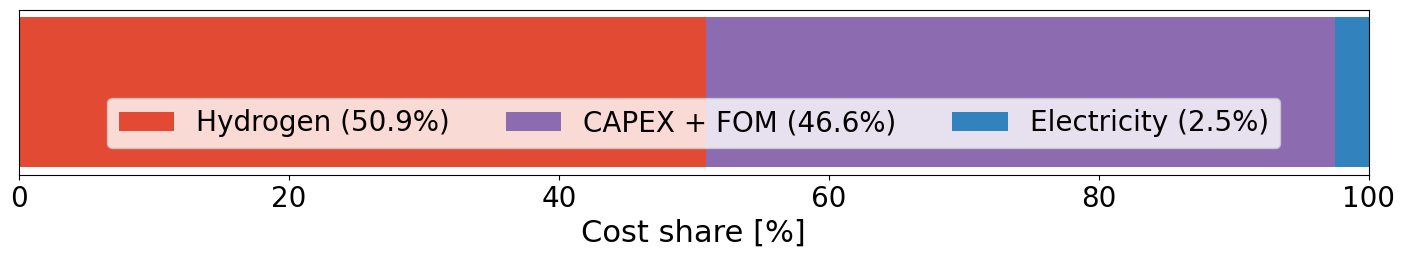

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# =========================================================
# ===================== GLOBAL STYLE ======================
# =========================================================
plt.rcParams.update({
    "axes.labelsize": 22,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20
})

# =========================================================
# ===================== COST COMPONENTS ===================
# =========================================================
capex_fom     = dme_obj          # M€
h2_cost_tot   = sum(h2_cost)     # M€
elec_cost_tot = sum(e_cost)      # M€

total_cost = capex_fom + h2_cost_tot + elec_cost_tot
if total_cost == 0:
    raise ValueError("Total cost is zero, cannot compute breakdown")

# =========================================================
# ===================== COST SHARES (%) ===================
# =========================================================
cost_breakdown = {
    "CAPEX + FOM": capex_fom / total_cost * 100,
    "Hydrogen":    h2_cost_tot / total_cost * 100,
    "Electricity": elec_cost_tot / total_cost * 100,
}

# Remove negligible components
cost_breakdown = {k: v for k, v in cost_breakdown.items() if v > 0.1}

# Sort by decreasing share
cost_breakdown = dict(
    sorted(cost_breakdown.items(), key=lambda x: x[1], reverse=True)
)

# =========================================================
# ===================== PLOT ==============================
# =========================================================
fig, ax = plt.subplots(figsize=(15, 3))

colors = {
    "CAPEX + FOM": "#8c6bb1",
    "Hydrogen":    "#e34a33",
    "Electricity": "#3182bd",
}

left = 0
for label, value in cost_breakdown.items():
    ax.barh(
        y=0,
        width=value,
        left=left,
        color=colors[label],
        label=f"{label} ({value:.1f}%)"
    )
    left += value

# =========================================================
# ===================== AXES ==============================
# =========================================================
ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_xlabel("Cost share [%]")

# =========================================================
# ===================== LEGEND ============================
# =========================================================
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.55),   # 🔑 à l’intérieur du canvas
    ncol=len(cost_breakdown),
    frameon=True
)

# =========================================================
# ===================== LAYOUT FIX ========================
# =========================================================
fig.subplots_adjust(
    left=0.08,
    right=0.98,
    bottom=0.35,
    top=0.90       # 🔑 supprime le blanc au-dessus
)

# =========================================================
# ===================== SAVE ==============================
# =========================================================
plt.savefig(
    os.path.join(scenario_result_folder,"dme_cost_breakdown.pdf"),
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.02
)
plt.show()


- Methanol production cost for Dmeoh route

In [20]:
meoh = dmeoh.INLAND.METHANOL_PLANTS

print(colored('METHANOL Plants Summary:', 'blue', attrs=['bold', 'underline']))
print('Methanol Plant Capacity (GW):', round(meoh.capacity,3))

# Electricity cost of efuel plants 
e_price = dmeoh.INLAND_BALANCE.electricity
e_cons = dmeoh.INLAND.METHANOL_PLANTS.e_consumed 
e_cost = [p * c for p, c in zip(e_price, e_cons)] # M€ 

# Hydrogen cost of efuel plants
h2_price = dmeoh.INLAND_BALANCE.hydrogen 
h2_cons = dmeoh.INLAND.METHANOL_PLANTS.h2_consumed 
h2_cost = [p * c for p, c in zip(h2_price, h2_cons)] # M€ 

# Carbon dioxide cost
co2_price = dmeoh.CO2_QUOTA.co2_neutral 
co2_price = -co2_price[0] 
co2_cons = dmeoh.INLAND.METHANOL_PLANTS.co2_consumed 
co2_cost = [co2_price * c for c in co2_cons] # M€


# Objectives of efuel plants
methanol_obj = dmeoh.INLAND.METHANOL_PLANTS.cost  # M€

print(f'Objective of Methanol Plants:', round(methanol_obj, 3), 'M€\n')

print(colored(f'COMMODITIES CONSUMPTION:', 'blue'))
print(f'Hydrogen consumption:', round(sum(h2_cons), 3), 'GWh')
print(f'Hydrogen consumption:', round(sum(h2_cons)/lhv_h2, 3), 'GWh')
print(f'Carbon dioxide consumption:', round(sum(co2_cons), 3), 'kton')
print(f'Electricity consumption:', round(sum(e_cons), 3), 'GWh\n')

print(colored(f'COMMODITIES COST:', 'blue'))
print(f'Hydrogen cost:', round(sum(h2_cost), 3), 'M€') 
print(f'Electricity cost:', round(sum(e_cost), 3), 'M€\n')


print(colored(f'Methanol Plants:', 'blue'))

methanol_prod = dmeoh.INLAND.METHANOL_PLANTS.methanol_produced  
print(f'Methanol production:', round(sum(methanol_prod), 3), 'GWh\n') 

total_cost = sum(e_cost) + sum(h2_cost) + methanol_obj
print(f'Total cost:', round(total_cost, 3), 'M€')
print(f'Methanol production cost per MWh:', round(1000*total_cost / sum(methanol_prod), 3), '€/MWh') if sum(methanol_prod) > 0 else 0 
print(f"Methanol production cost per kg:", round(lhv_methanol*total_cost / sum(methanol_prod), 3), '€/kg') if sum(methanol_prod) > 0 else 0 
print(f"Methanol production cost per ton:", round(1000*lhv_methanol*total_cost / sum(methanol_prod), 3), '€/ton') if sum(methanol_prod) > 0 else 0

meoh_price = [e + h2 + methanol_obj/len(e_cons) for e, h2 in zip(e_cost, h2_cost)]  # M€
meoh_cost_hourly = [c / p if p > 0 else 0 for c, p in zip(meoh_price, methanol_prod)] # M€/GWh

METHANOL Plants Summary:
Methanol Plant Capacity (GW): 0.773
Objective of Methanol Plants: 74.445 M€

COMMODITIES CONSUMPTION:
Hydrogen consumption: 8068.371 GWh
Hydrogen consumption: 242.075 GWh
Carbon dioxide consumption: 1587.191 kton
Electricity consumption: 344.084 GWh

COMMODITIES COST:
Hydrogen cost: 605.128 M€
Electricity cost: 37.397 M€

Methanol Plants:
Methanol production: 6383.519 GWh

Total cost: 716.971 M€
Methanol production cost per MWh: 112.316 €/MWh
Methanol production cost per kg: 0.619 €/kg
Methanol production cost per ton: 618.861 €/ton


- Cost breakdown for methanol production cost for Dmeoh route

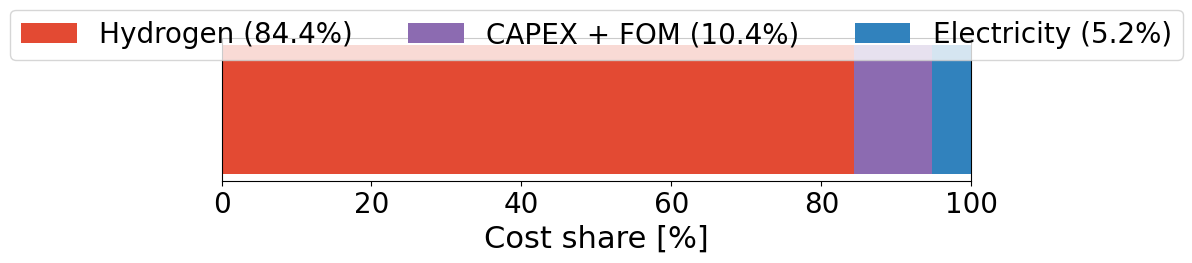

In [21]:
# =========================================================
# ===================== COST COMPONENTS ===================
# =========================================================
capex_fom = methanol_obj                  # M€
h2_cost_tot = sum(h2_cost)                # M€
elec_cost_tot = sum(e_cost)               # M€

total_cost = capex_fom + h2_cost_tot + elec_cost_tot

if total_cost == 0:
    raise ValueError("Total cost is zero, cannot compute breakdown")

# =========================================================
# ===================== COST SHARES (%) ===================
# =========================================================
cost_breakdown = {
    "Hydrogen": h2_cost_tot / total_cost * 100,
    "CAPEX + FOM": capex_fom / total_cost * 100,
    "Electricity": elec_cost_tot / total_cost * 100,
}

# Remove negligible components if needed
cost_breakdown = {k: v for k, v in cost_breakdown.items() if v > 0.1}

# -------- SORT BY DESCENDING SHARE --------
cost_breakdown = dict(
    sorted(cost_breakdown.items(), key=lambda x: x[1], reverse=True)
)

# =========================================================
# ===================== PLOT ==============================
# =========================================================
fig, ax = plt.subplots(figsize=(11, 3))

left = 0
colors = {
    "Hydrogen": "#e34a33",
    "CAPEX + FOM": "#8c6bb1",
    "Electricity": "#3182bd",
}

for label, value in cost_breakdown.items():
    ax.barh(
        y=0,
        width=value,
        left=left,
        color=colors[label],
        label=f"{label} ({value:.1f}%)"
    )
    left += value

ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_xlabel("Cost share [%]")

ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.3),
    ncol=len(cost_breakdown)
)

plt.tight_layout()
plt.show()


- Production cost for Dmeoh route

In [22]:
print(colored('DMEOH Plants Summary:', 'blue', attrs=['bold', 'underline']))
print('DMEOH Plant Capacity (GW):', round(dmeoh.INLAND.DMEOH_PLANTS.capacity,3)) 

# Methanol cost of efuel plants
meoh_price = meoh_cost_hourly
meoh_cons = dmeoh.INLAND.DMEOH_PLANTS.methanol_consumed 
meoh_cost = [p * c for p, c in zip(meoh_price, meoh_cons)] # M€  

# Objectives of efuel plants
dme_obj = dmeoh.INLAND.DMEOH_PLANTS.cost + dmeoh.INLAND.METHANOL_PLANTS.cost # M€

print('')
print(f'Objective of DMEOH Plants:', round(dme_obj, 3), 'M€\n')

print(colored(f'COMMODITIES CONSUMPTION:', 'blue'))
print(f'Methanol consumption:', round(sum(meoh_cons), 3), 'GWh\n') 

print(colored(f'COMMODITIES COST:', 'blue'))
print(f'meoh_price cost:', round(sum(meoh_cost), 3), 'M€\n')  


print(colored(f'DME Plants:', 'blue'))

dme_prod = dmeoh.INLAND.DMEOH_PLANTS.dme_produced 
print(f'DME production:', round(sum(dme_prod), 3), 'GWh\n') 

total_cost = sum(meoh_cost) + dme_obj
print(f'Total cost:', round(total_cost, 3), 'M€')
print(f'DME production cost per MWh:', round(1000*total_cost / sum(dme_prod), 3), '€/MWh') if sum(dme_prod) > 0 else 0 
print(f"DME production cost per kg:", round(lhv_dme*total_cost / sum(dme_prod), 3), '€/kg') if sum(dme_prod) > 0 else 0 
print(f"DME production cost per ton:", round(1000*lhv_dme*total_cost / sum(dme_prod), 3), '€/ton') if sum(dme_prod) > 0 else 0


dme_price = [m + dme_obj/len(meoh_cost) for m in meoh_cost]  # M€
dme_cost = [c / p if p > 0 else 0 for c, p in zip(dme_price, dme_prod)] # M€/GWh

DMEOH Plants Summary:
DMEOH Plant Capacity (GW): 0.758

Objective of DMEOH Plants: 138.562 M€

COMMODITIES CONSUMPTION:
Methanol consumption: 6383.519 GWh

COMMODITIES COST:
meoh_price cost: 678.02 M€

DME Plants:
DME production: 6640.0 GWh

Total cost: 816.582 M€
DME production cost per MWh: 122.979 €/MWh
DME production cost per kg: 0.985 €/kg
DME production cost per ton: 985.064 €/ton


- Cost breakdown for methanol plant and dmeoh plant

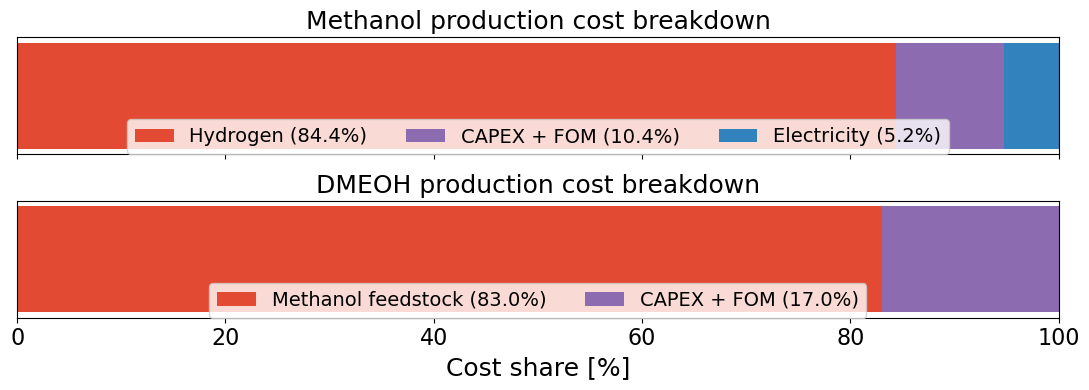

In [23]:
# =========================================================
# ===================== COST BREAKDOWN ====================
# =========================================================

# ---------- METHANOL ----------
capex_fom_meoh = methanol_obj
h2_cost_tot = sum(h2_cost)
elec_cost_tot = sum(e_cost)

total_cost_meoh = capex_fom_meoh + h2_cost_tot + elec_cost_tot

if total_cost_meoh == 0:
    raise ValueError("Total methanol cost is zero")

cost_breakdown_meoh = {
    "Hydrogen": h2_cost_tot / total_cost_meoh * 100,
    "CAPEX + FOM": capex_fom_meoh / total_cost_meoh * 100,
    "Electricity": elec_cost_tot / total_cost_meoh * 100,
}

cost_breakdown_meoh = dict(
    sorted(cost_breakdown_meoh.items(), key=lambda x: x[1], reverse=True)
)

# ---------- DMEOH ----------
meoh_cost_tot = sum(meoh_cost)
capex_fom_dmeoh = dme_obj

total_cost_dmeoh = meoh_cost_tot + capex_fom_dmeoh

if total_cost_dmeoh == 0:
    raise ValueError("Total DMEOH cost is zero")

cost_breakdown_dmeoh = {
    "Methanol feedstock": meoh_cost_tot / total_cost_dmeoh * 100,
    "CAPEX + FOM": capex_fom_dmeoh / total_cost_dmeoh * 100,
}

cost_breakdown_dmeoh = dict(
    sorted(cost_breakdown_dmeoh.items(), key=lambda x: x[1], reverse=True)
)

# =========================================================
# ===================== PLOT ==============================
# =========================================================
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    figsize=(11, 4),
    sharex=True
)

colors = {
    "Hydrogen": "#e34a33",
    "Electricity": "#3182bd",
    "Methanol feedstock": "#e34a33",
    "CAPEX + FOM": "#8c6bb1",
}

# ---------------- TOP: METHANOL ----------------
left = 0
for label, value in cost_breakdown_meoh.items():
    ax_top.barh(
        y=0,
        width=value,
        left=left,
        color=colors[label],
        label=f"{label} ({value:.1f}%)"
    )
    left += value

ax_top.set_xlim(0, 100)
ax_top.set_yticks([])
ax_top.set_title("Methanol production cost breakdown", fontsize=18)

# 🔹 AXE X FONT SIZE
ax_top.tick_params(axis="x", labelsize=16)

ax_top.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.38),
    ncol=len(cost_breakdown_meoh),
    fontsize=14
)

# ---------------- BOTTOM: DMEOH ----------------
left = 0
for label, value in cost_breakdown_dmeoh.items():
    ax_bot.barh(
        y=0,
        width=value,
        left=left,
        color=colors[label],
        label=f"{label} ({value:.1f}%)"
    )
    left += value

ax_bot.set_xlim(0, 100)
ax_bot.set_yticks([])
ax_bot.set_xlabel("Cost share [%]", fontsize=18)
ax_bot.set_title("DMEOH production cost breakdown", fontsize=18)

# 🔹 AXE X FONT SIZE
ax_bot.tick_params(axis="x", labelsize=16)

ax_bot.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 0.38),
    ncol=len(cost_breakdown_dmeoh),
    fontsize=14
)

plt.tight_layout()
plt.savefig(os.path.join(scenario_result_folder,"cost_breakdown_meoh_dmeoh.pdf"), dpi=300)
plt.show()


- Methanol supply and storage for dmeoh route

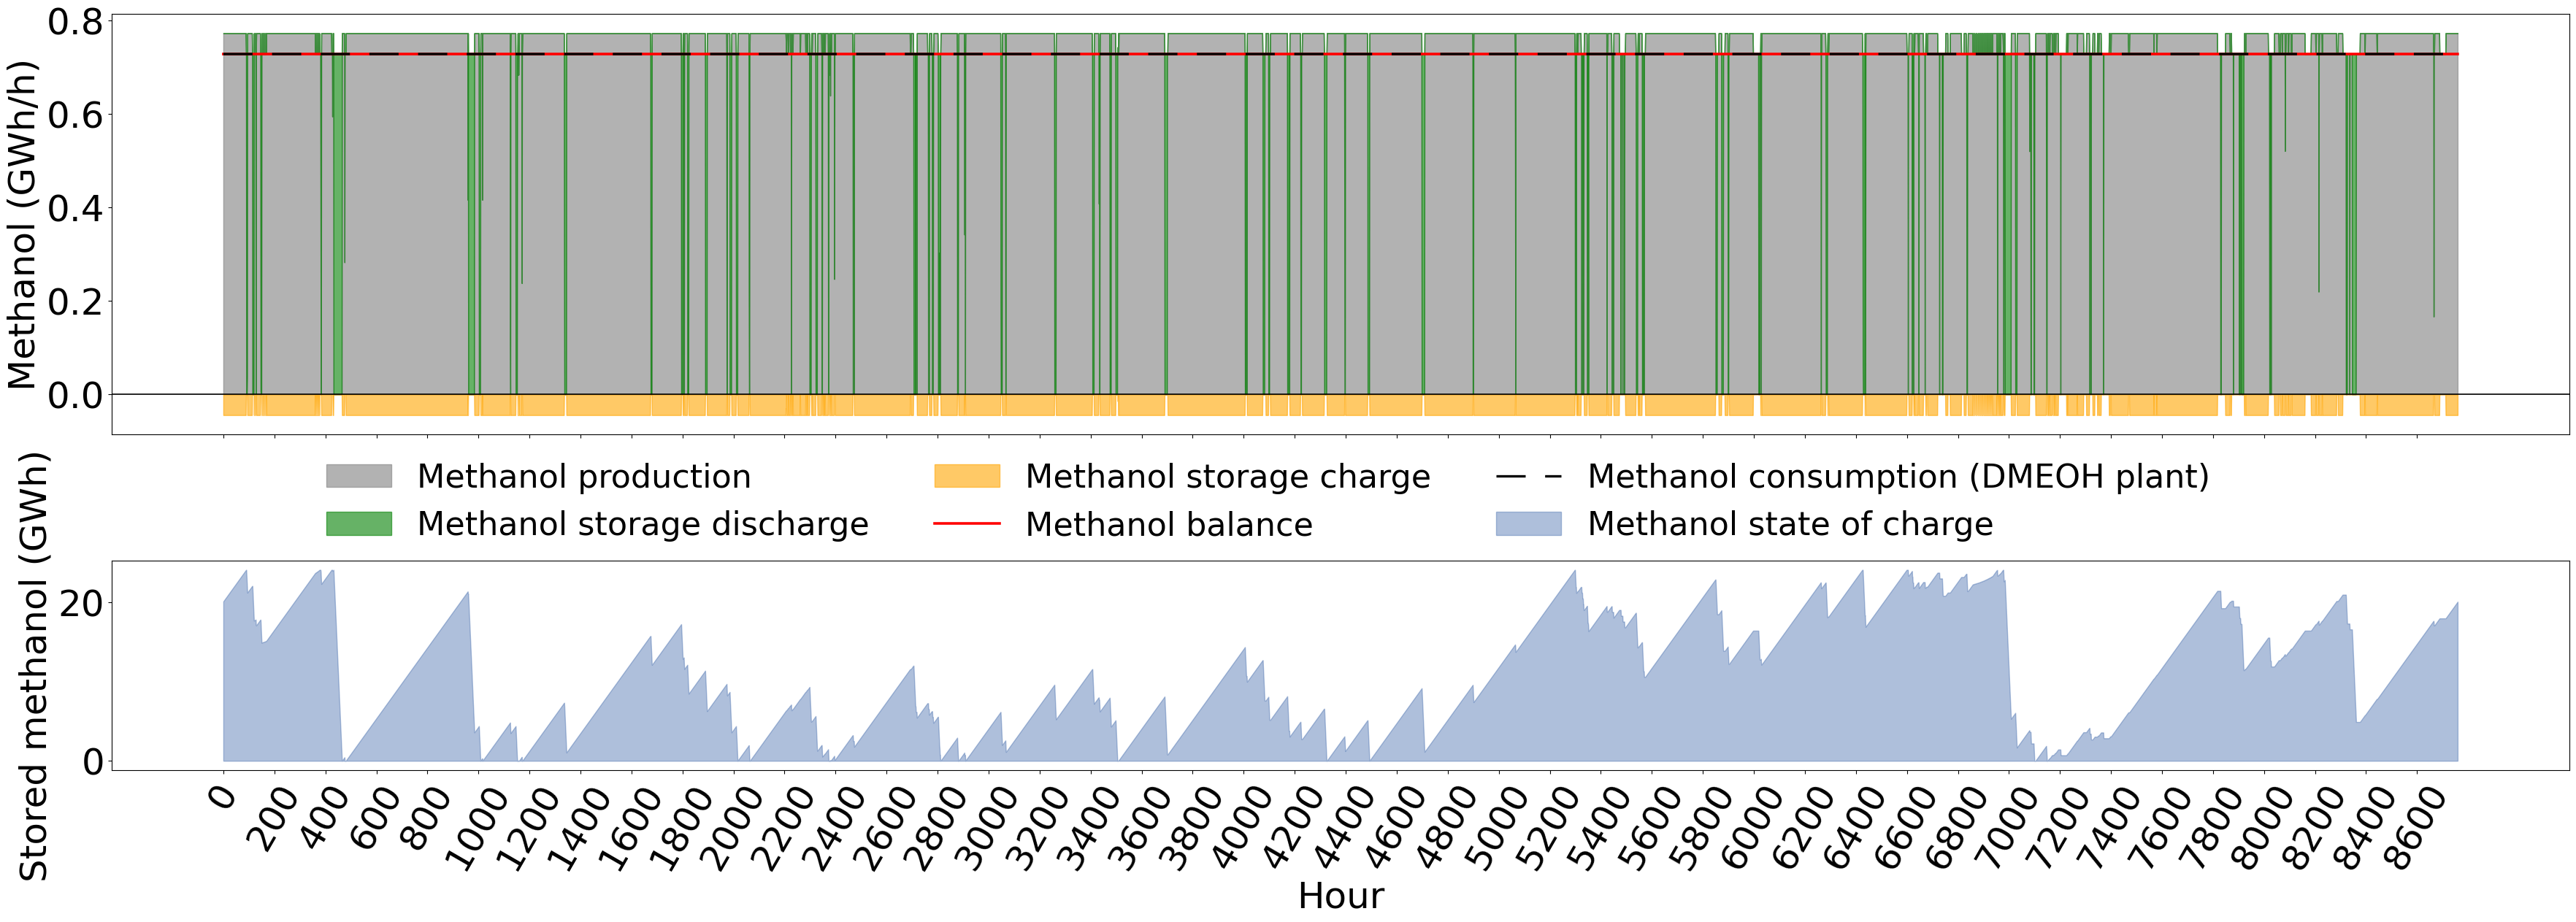

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# ================= GLOBAL STYLE =================
plt.rcParams.update({
    "axes.labelsize": 36,
    "axes.titlesize": 36,
    "xtick.labelsize": 36,
    "ytick.labelsize": 36,
    "legend.fontsize": 32
})

# ================= DATA =================
meoh_prod  = np.array(meoh.methanol_produced)
meoh_disch = np.array(dmeoh.INLAND.METHANOL_STORAGE.methanol_discharged)
meoh_char  = np.array(dmeoh.INLAND.METHANOL_STORAGE.methanol_charged)
meoh_cons  = np.array(dmeoh.INLAND.DMEOH_PLANTS.methanol_consumed)
soc        = np.array(dmeoh.INLAND.METHANOL_STORAGE.methanol_stored)

meoh_balance = meoh_prod + meoh_disch - meoh_char
hours = np.arange(len(meoh_prod))

# ================= FIGURE =================
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    figsize=(36, 14),                 # un peu moins haut
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1], "hspace": 0.4}
)

# ================= TOP =================
ax_top.fill_between(
    hours, 0, meoh_prod,
    color="gray", alpha=0.6,
    label="Methanol production"
)

ax_top.fill_between(
    hours, meoh_prod, meoh_prod + meoh_disch,
    color="green", alpha=0.6,
    label="Methanol storage discharge"
)

ax_top.fill_between(
    hours, 0, -meoh_char,
    color="orange", alpha=0.6,
    label="Methanol storage charge"
)

ax_top.plot(
    hours, meoh_balance,
    color="red", lw=2.6,
    label="Methanol balance"
)

line_cons, = ax_top.plot(
    hours, meoh_cons,
    color="black", lw=2.4,
    label="Methanol consumption (DMEOH plant)"
)
line_cons.set_dashes([12, 8])

ax_top.axhline(0, color="black", lw=1.2)
ax_top.set_ylabel("Methanol (GWh/h)")
ax_top.grid(False)

# ================= BOTTOM =================
ax_bot.fill_between(
    hours, 0, soc,
    color="#4C72B0", alpha=0.45,
    label="Methanol state of charge"
)

ax_bot.set_ylabel("Stored methanol (GWh)")
ax_bot.set_xlabel("Hour")
ax_bot.grid(False)

xticks = np.arange(0, len(hours), 200)
ax_bot.set_xticks(xticks)
ax_bot.set_xticklabels(xticks, rotation=60)

# ================= SINGLE LEGEND =================
handles_t, labels_t = ax_top.get_legend_handles_labels()
handles_b, labels_b = ax_bot.get_legend_handles_labels()

fig.legend(
    handles_t + handles_b,
    labels_t + labels_b,
    ncol=3,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.47),   # 🔑 proche du bord supérieur
    frameon=False
)

# ================= LAYOUT (CRITICAL PART) =================
fig.subplots_adjust(
    left=0.06,
    right=0.995,
    bottom=0.14,
    top=0.88        # 🔑 supprime le blanc parasite
)

# ================= SAVE =================
plt.savefig(
    os.path.join(scenario_result_folder,"methanol_production_storage_balance.pdf"),
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.02   # 🔑 très important
)
plt.show()


- Electicity consumption for low carbon fuels production and electicity price

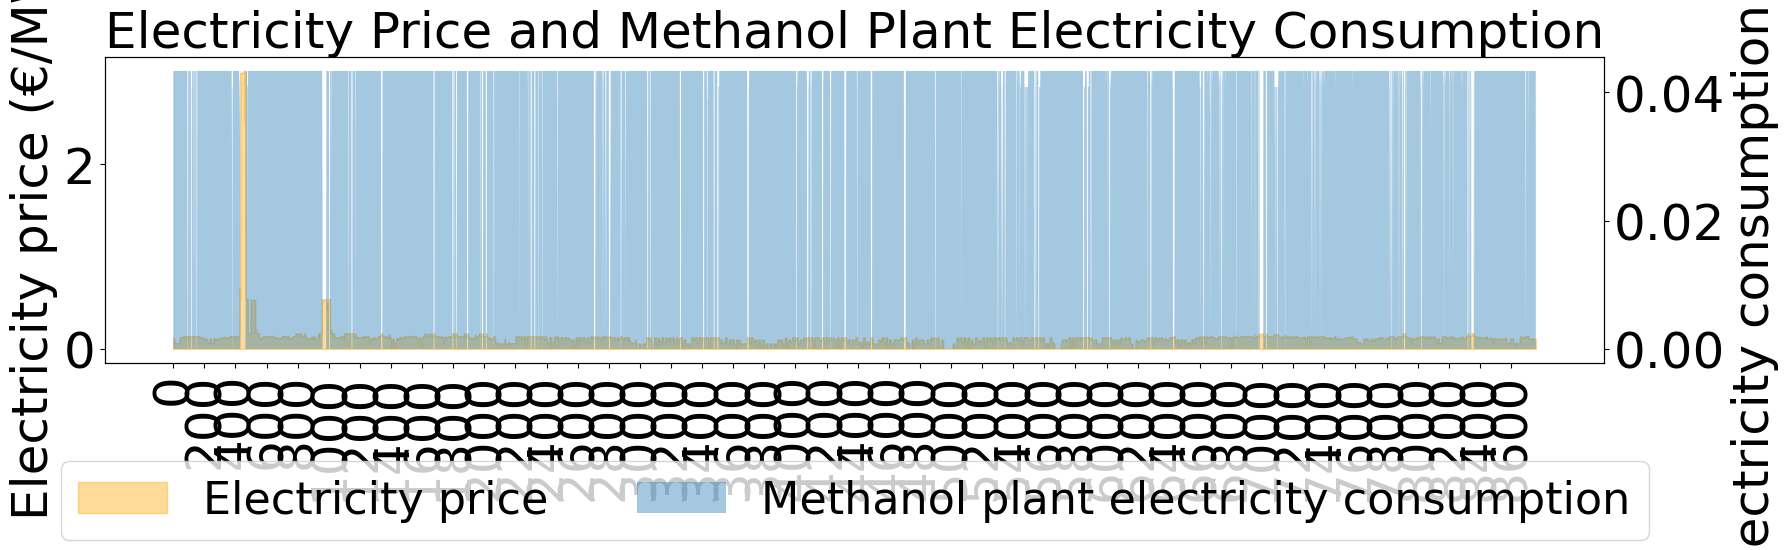

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# ================= DATA =================
elec_price = np.array(sys.INLAND_BALANCE.electricity)
meoh_elec  = np.array(sys.INLAND.METHANOL_PLANTS.e_consumed)
hours = np.arange(len(elec_price))

# ================= PLOT =================
fig, ax1 = plt.subplots(figsize=(18, 6))

# --- Electricity price (left y-axis, fill_between) ---
ax1.fill_between(
    hours,
    0,
    elec_price,
    alpha=0.4,
    label='Electricity price',
    color='orange'
)
ax1.set_ylabel('Electricity price (€/MWh)')
ax1.grid(False)

# --- Methanol plant electricity consumption (right y-axis, fill_between) ---
ax2 = ax1.twinx()
ax2.fill_between(
    hours,
    0,
    meoh_elec,
    alpha=0.4,
    label='Methanol plant electricity consumption'
)
ax2.set_ylabel('Electricity consumption (GWh)')
ax2.grid(False)

# ================= X-TICKS =================
xticks = np.arange(0, len(hours), 200)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=90)

# ================= LEGEND =================
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=2
)

# ================= TITLE =================
plt.title('Electricity Price and Methanol Plant Electricity Consumption')
plt.tight_layout()
plt.savefig(os.path.join(scenario_result_folder,"methanol_electricity_price_consumption.pdf"), dpi=300)
plt.show()


Node,Max Storage capacity,Pre-installed Storage capacity,New storage capacity,Installed Capacity,Max Flow rate,Max Discharge Flow rate,Max Charged Flow rate
METHANOL_STORAGE,100,0,25.013699,25.013699,20.000000,0.757991,0.757991


Name,Storage capacity GWh,Net yearly energy stored GWh,Max charge flow rate GWh,Energy charged yearly GWh,Max discharge flow rate GWh,Energy discharged yearly GWh
METHANOL_STORAGE,25.013699,0.000000,0.757991,378.686050,0.757991,378.686050


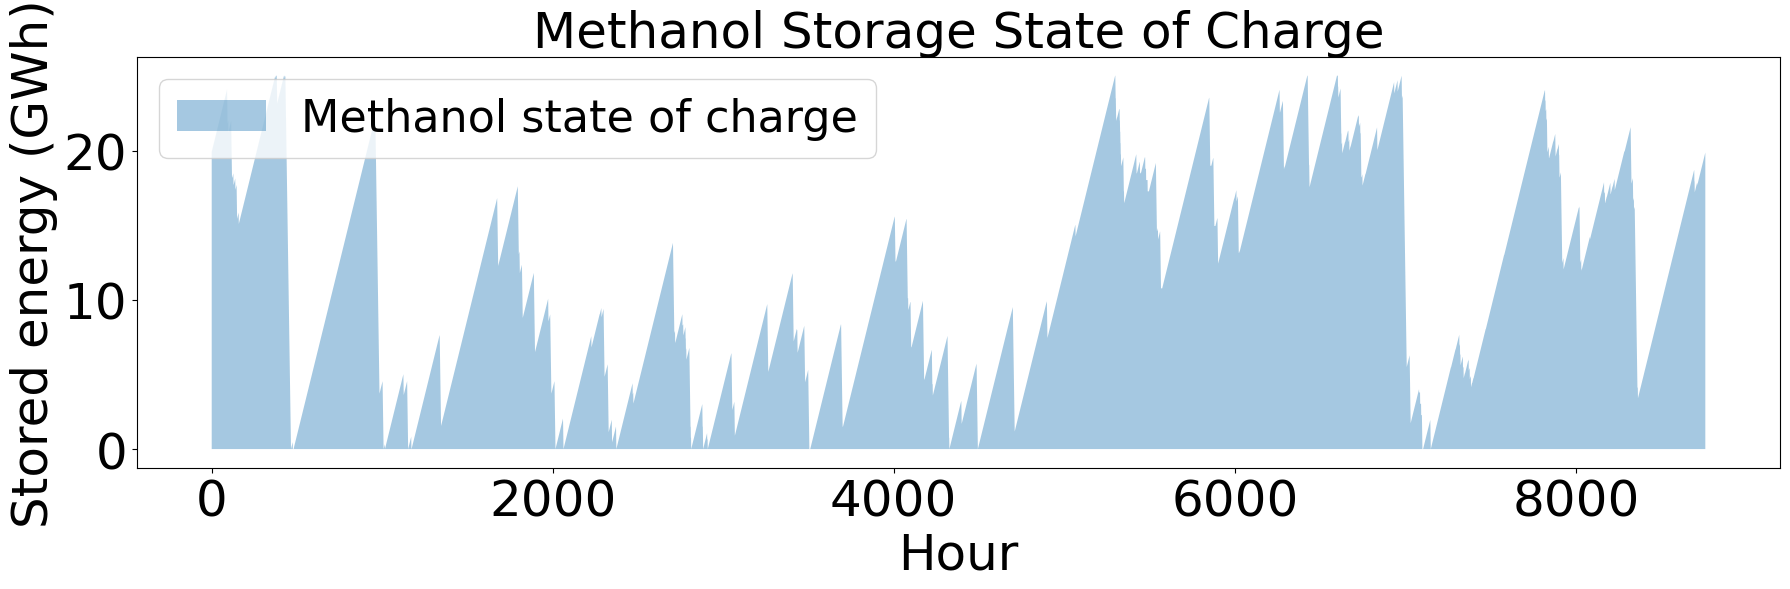

In [26]:
# if methanol == True:
# Storage
display(sys.INLAND.METHANOL_STORAGE.cap_table())
display(sys.INLAND.METHANOL_STORAGE.stat(unit='GWh', unit_energy='GWh') ) 



# ================= DATA =================
soc = np.array(sys.INLAND.METHANOL_STORAGE.methanol_stored)
hours = np.arange(len(soc))

# ================= PLOT =================
fig, ax = plt.subplots(figsize=(18, 6))

ax.fill_between(
    hours,
    0,
    soc,
    alpha=0.4,
    label='Methanol state of charge'
)

ax.set_ylabel('Stored energy (GWh)')
ax.set_xlabel('Hour')
ax.set_title('Methanol Storage State of Charge')
ax.grid(False)
ax.legend()

plt.tight_layout()
plt.show()


- DME supply and storage

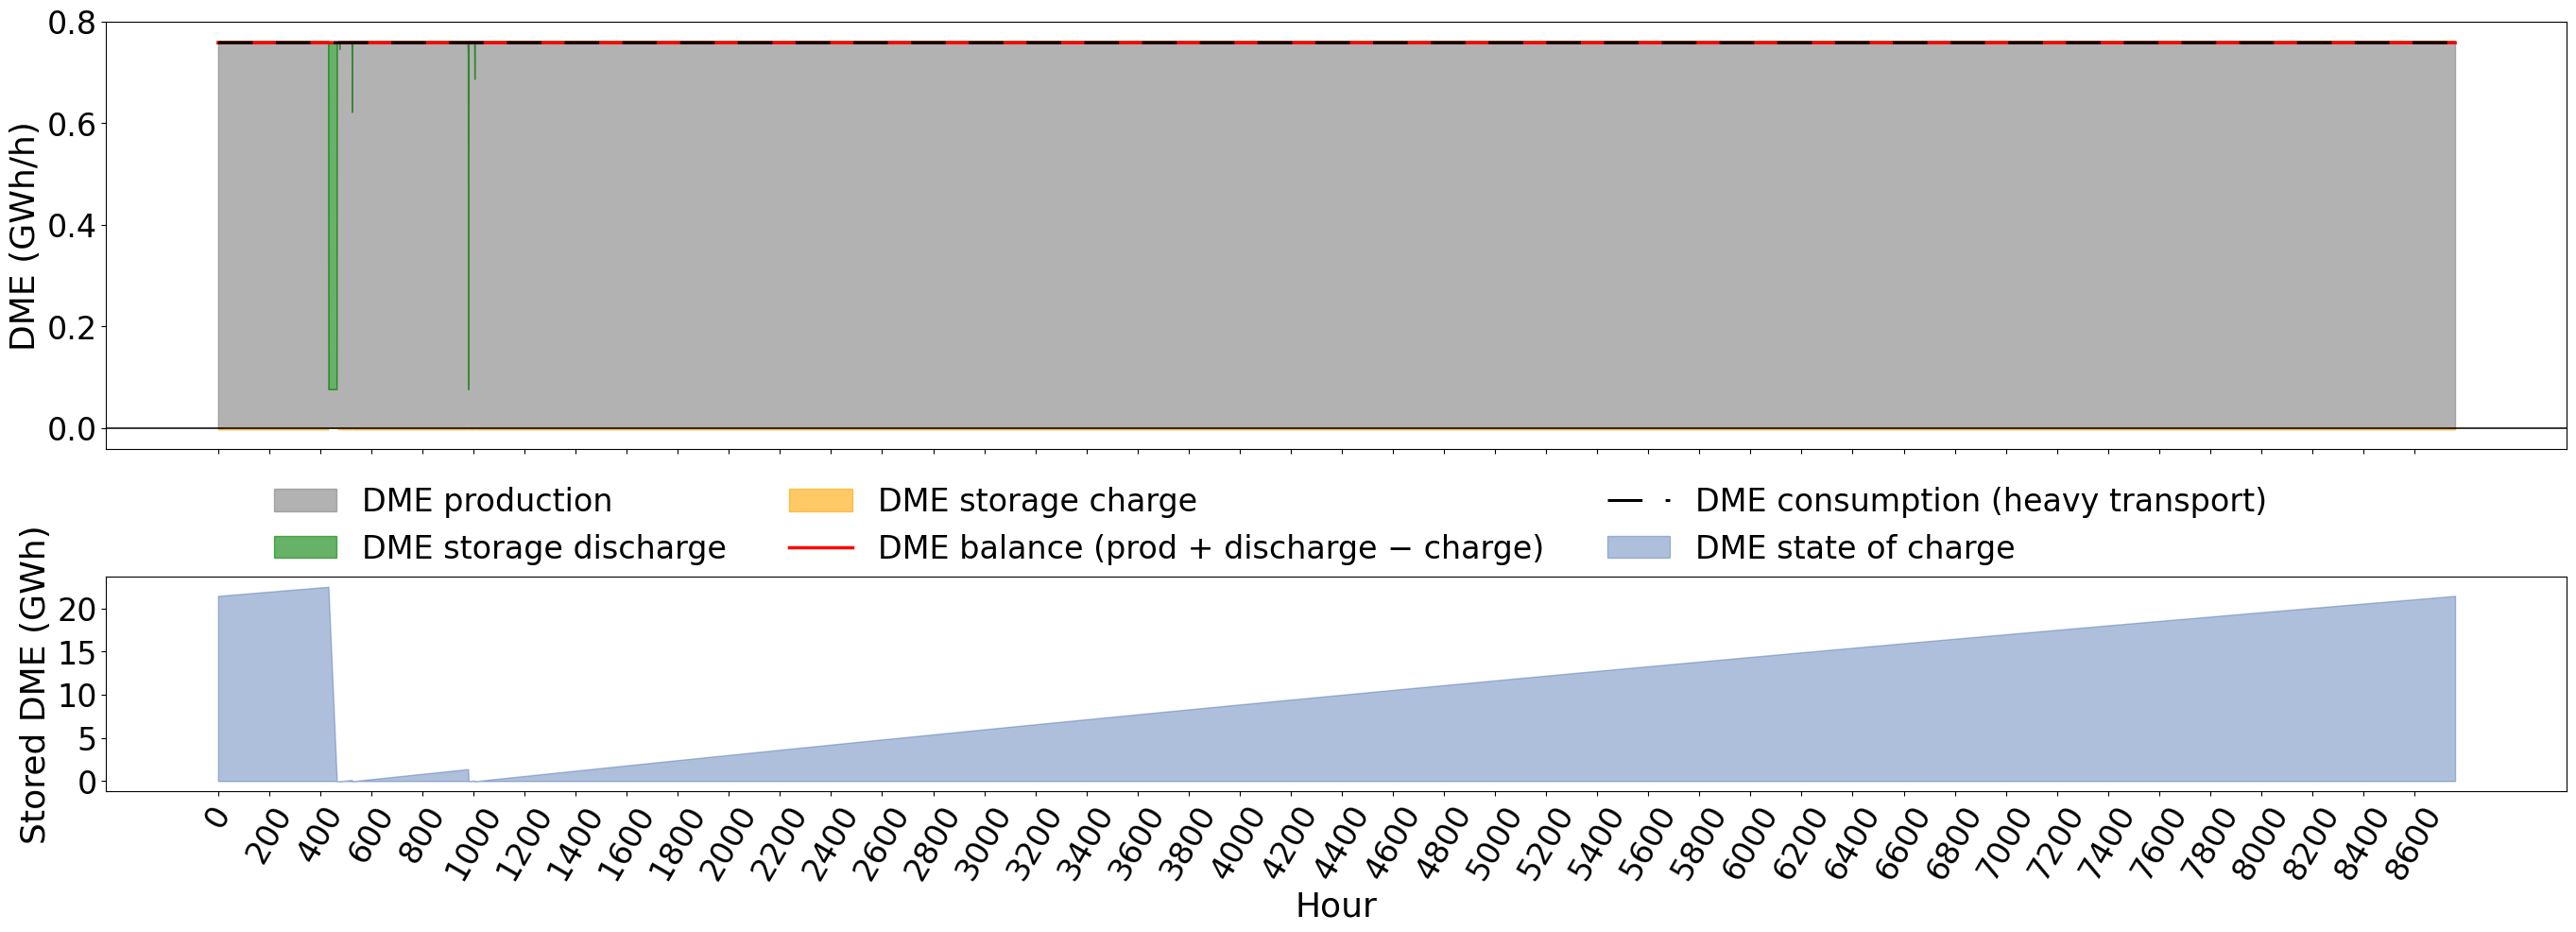

In [27]:
# ================= GLOBAL STYLE =================
plt.rcParams.update({
    "axes.labelsize": 26,
    "axes.titlesize": 26,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "legend.fontsize": 24
})

# ================= DATA =================
dme_prod  = np.array(dme.INLAND.DME_PLANTS.dme_produced)
dme_disch = np.array(dme.INLAND.DME_STORAGE.dme_discharged)
dme_char  = np.array(dme.INLAND.DME_STORAGE.dme_charged)

dme_cons = np.array([
    t + s
    for t, s in zip(
        sys.INLAND.demand_efuel_truck,
        sys.INLAND.demand_efuel_shipping
    )
])

soc = np.array(dme.INLAND.DME_STORAGE.dme_stored)

# ================= BALANCE =================
dme_balance = dme_prod + dme_disch - dme_char
hours = np.arange(len(dme_prod))

# ================= FIGURE =================
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    figsize=(28, 11),
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1], "hspace": 0.4}
)

# =================================================
# ============ TOP: PROD / STORAGE =================
# =================================================
ax_top.fill_between(
    hours, 0, dme_prod,
    alpha=0.6, color="gray",
    label="DME production"
)

ax_top.fill_between(
    hours, dme_prod, dme_prod + dme_disch,
    alpha=0.6, color="green",
    label="DME storage discharge"
)

ax_top.fill_between(
    hours, 0, -dme_char,
    alpha=0.6, color="orange",
    label="DME storage charge"
)

ax_top.plot(
    hours, dme_balance,
    color="red", linewidth=2.5,
    label="DME balance (prod + discharge − charge)"
)

line_cons, = ax_top.plot(
    hours, dme_cons,
    color="black", linewidth=2.2,
    label="DME consumption (heavy transport)"
)
line_cons.set_dashes([12, 8])

ax_top.axhline(0, color="black", linewidth=1.1)
ax_top.set_ylabel("DME (GWh/h)")
ax_top.grid(False)

# =================================================
# ============== BOTTOM: SOC ======================
# =================================================
ax_bot.fill_between(
    hours, 0, soc,
    alpha=0.45, color="#4C72B0",
    label="DME state of charge"
)

ax_bot.set_ylabel("Stored DME (GWh)")
ax_bot.set_xlabel("Hour")
ax_bot.grid(False)

# ================= X-TICKS =================
xticks = np.arange(0, len(hours), 200)
ax_bot.set_xticks(xticks)
ax_bot.set_xticklabels(xticks, rotation=60)
ax_bot.set_yticks(np.arange(0, max(soc)+1, step=5))
ax_top.set_yticks(np.arange(0, 1, step=0.2))

# =================================================
# ================= SINGLE LEGEND =================
# =================================================
handles_t, labels_t = ax_top.get_legend_handles_labels()
handles_b, labels_b = ax_bot.get_legend_handles_labels()

fig.legend(
    handles_t + handles_b,
    labels_t + labels_b,
    ncol=3,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.46),
    frameon=False
)

# =================================================
# ================= LAYOUT FIX (KEY) ===============
# =================================================
fig.subplots_adjust(
    left=0.06,
    right=0.99,
    bottom=0.14,
    top=0.88      # 🔑 coupe le blanc au-dessus
)

# ================= SAVE =================
plt.savefig(
    os.path.join(scenario_result_folder,"dme_production_storage_balance.pdf"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()
